In [1]:
# Silent Warnings
import warnings
warnings.filterwarnings('ignore')

# Database

> The data set contains socio-demographic and firmographic features about 2.240 customers who were contacted. Additionally, it contains a flag for those customers who responded the campaign, by buying the product.

In [2]:
# Importing libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import seaborn as sns
import numpy as np

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path
file_path = '/content/drive/MyDrive/PS Ifood/ml_project1_data (2).csv'

df = pd.read_csv(file_path)
print("The dataframe contains {0} rows and {1} columns.".format(df.shape[0], df.shape[1]))

Mounted at /content/drive
The dataframe contains 2240 rows and 29 columns.


In [5]:
# Checking for unique ids
print("We have {0} rows and {1} unique individuals.".format(df.shape[0], df["ID"].nunique()))

We have 2240 rows and 2240 unique individuals.


# 1. Data Transformation, Exploration, and Analysis

> Transforming Variables to Reveal Patterns
___

In [6]:
# Replace "Alone" with "Single" in the 'Marital_Status' column
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')

# Regardless of your Marital Status, if you have children at home, you are living with other people.

# Define conditions
conditions = [
    (df['Kidhome'] == 0) & (df['Teenhome'] == 0) & (df['Marital_Status'].isin(["Single", "Widow", "Divorced"])),
    (df['Kidhome'] != 0) | (df['Teenhome'] != 0) | (df['Marital_Status'].isin(["Together", "Married"])),
]

# Define corresponding values for each condition
choices = ['Living Alone', 'Living with Others']

# Apply conditions to create the 'InHouse' column
df['InHouse'] = np.select(conditions, choices, default='Other')

In [7]:
# Age of customer during the period of campaigns
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Year_Customer'] = df['Dt_Customer'].dt.year
df['Age'] = df["Year_Customer"] - df['Year_Birth']

# Education
df['EducationLevel'] = df['Education'].apply(lambda x: 'High' if x in ["Graduation","PhD","Master"] else ('Middle' if x in ["Basic"] else 'Low'))

# Total Number of Campaigns
df['TotalCampaignsAccepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Spent
df['Spent'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Total Purchases
df['TotalPurchases'] = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Average spend per purchase
df['AverageSpend'] = df['Spent'] / df['TotalPurchases']

# Variable to indicate parenthood
df['HasChildren'] = (df['Kidhome'] + df['Teenhome'] > 0).astype(int)

# Variable to indicate parenthood
df['ChildrenAtHome'] = (df['Kidhome'] + df['Teenhome'])

df.shape

(2240, 39)

> Additional treatments
___
Cleaning Marital Status and Dropping Constant Variables. We will remove records with "YOLO" and "Absurd" as marital status, as these categories are unclear and not representative (only 4 records).

In [8]:
df[df["Marital_Status"].isin(["YOLO", "Absurd"])].shape

(4, 39)

In [9]:
# Filtering all registers that are different from "YOLO", "Absurd"
df = df[~df["Marital_Status"].isin(["YOLO", "Absurd"])]

# The 'Z_CostContact' and 'Z_Revenue' columns are constant, so we can drop them as they do not provide any explanatory power.
df.drop(columns=["Z_CostContact", "Z_Revenue"], inplace=True)
df.shape

(2236, 37)

> Campaign Acceptance Rates
___


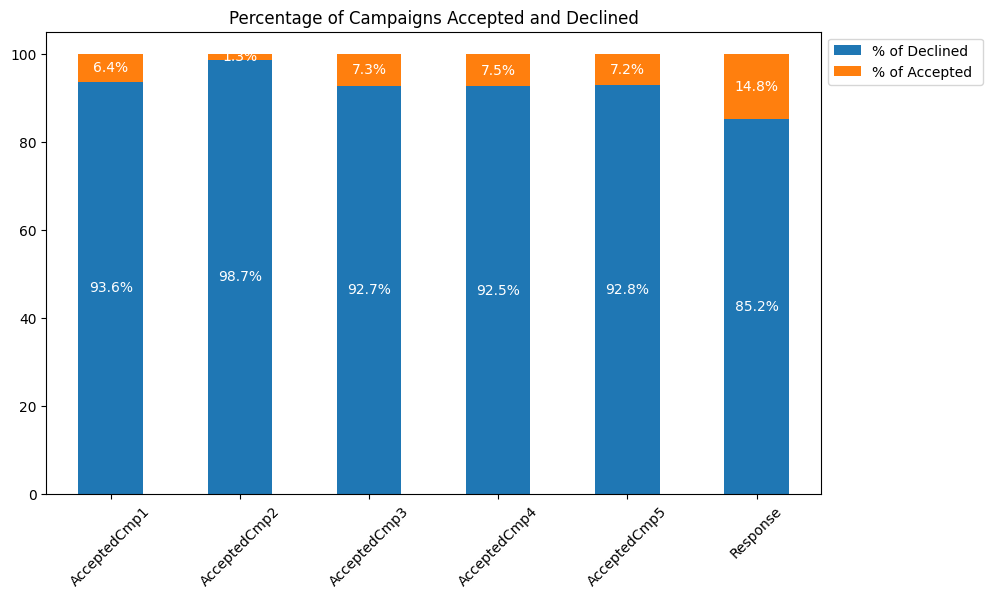

In [10]:
# Specify the columns you want to analyze
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# Calculate the percentage of 0's and 1's for each column
percentage_data = {
    col: (df[col].value_counts(normalize=True) * 100) for col in campaign_cols
}

# Convert to a DataFrame and fill missing values with 0
percentage_df = pd.DataFrame(percentage_data).T.fillna(0)
percentage_df.columns = ['% of Declined', '% of Accepted ']

# Plotting the stacked bar chart
ax = percentage_df.plot(
    kind='bar',
    stacked=True,
    color=['#1f77b4', '#ff7f0e'],
    figsize=(10, 6)
)

# Adding labels and title
plt.title('Percentage of Campaigns Accepted and Declined')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='',  bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)

# Display the percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(
        x + width / 2,
        y + height / 2,
        f'{height:.1f}%',
        ha='center',
        va='center',
        color='white'
    )

plt.show()


> Marital_Status share
___

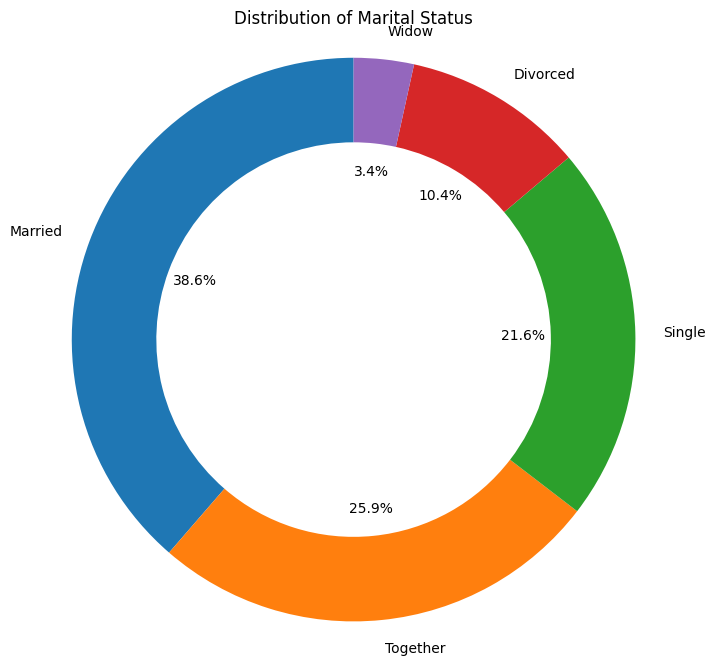

In [11]:
marital_status_counts = df['Marital_Status'].value_counts()

# Create the donut chart
plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.title('Distribution of Marital Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

> Number of Customers by Campaigns Accepted
___

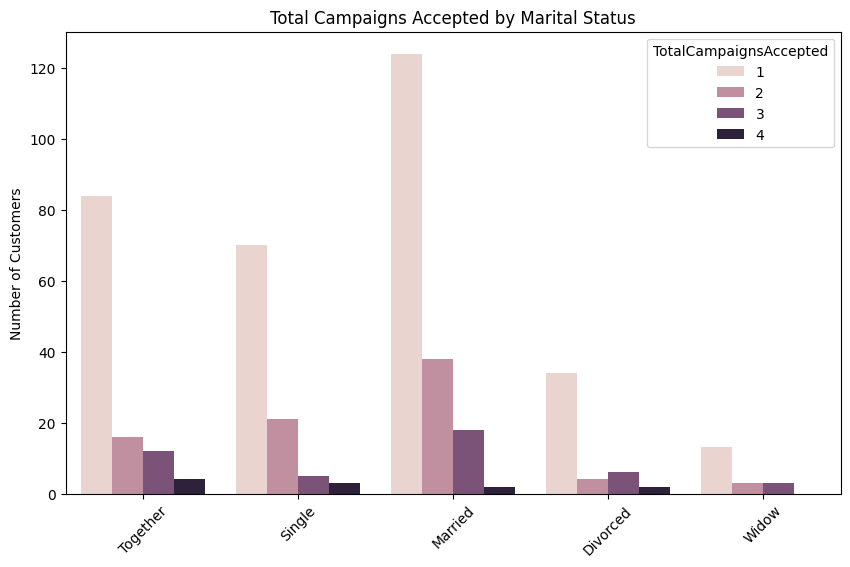

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it has columns 'TotalCampaignsAccepted' and 'Marital_Status'
plt.figure(figsize=(10, 6))
sns.countplot(x='Marital_Status', hue='TotalCampaignsAccepted', data=df[df["TotalCampaignsAccepted"]!=0])
plt.title('Total Campaigns Accepted by Marital Status')
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

> Income Distribution per Marital_Status
___



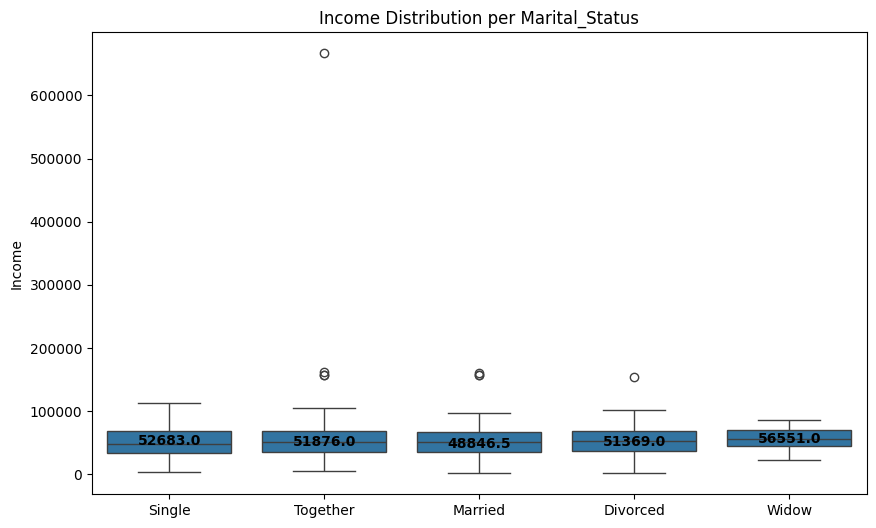

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Marital_Status', y='Income', data=df)

# Calculate the median (50th percentile) for each group and overlay it
medians = df.groupby('Marital_Status')['Income'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

plt.title('Income Distribution per Marital_Status')
plt.xlabel('')
plt.ylabel('Income')
plt.show()

> Acceptance Rate by Marital Status for Each Campaign
___

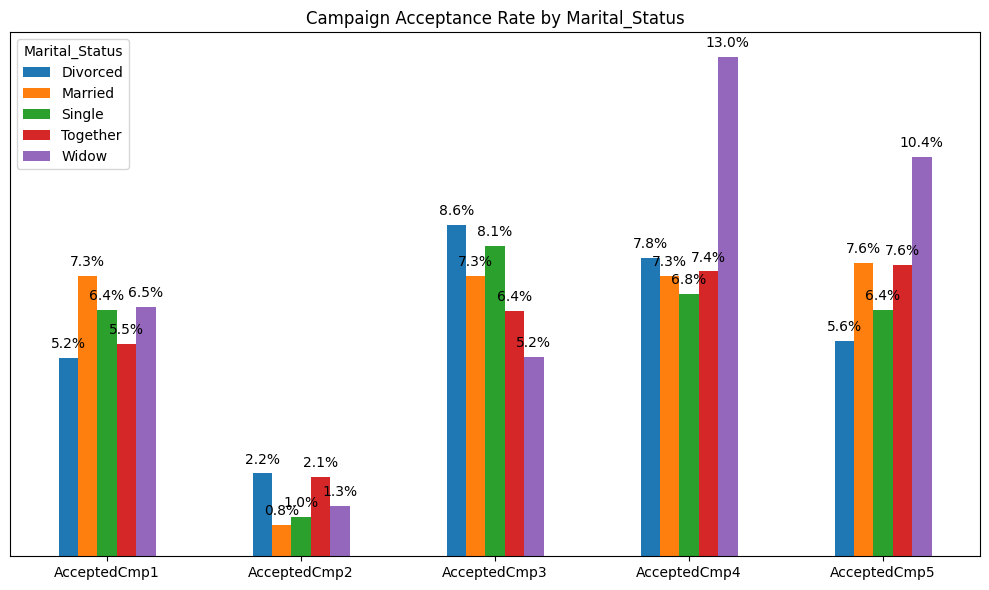

In [14]:
# Group by 'InHouse' and calculate the acceptance rate for each campaign
campaign_acceptance = df.groupby('Marital_Status')[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].mean() * 100

# Transpose the DataFrame for plotting
campaign_acceptance = campaign_acceptance.T

# Plotting the bar chart
ax = campaign_acceptance.plot(kind='bar', figsize=(10, 6))
plt.title('Campaign Acceptance Rate by Marital_Status')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
ax.tick_params(axis='y', which='both', left=False, labelleft=False) # Hide y-axis ticks and labels
plt.legend(title='Marital_Status')

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

> Acceptance Rate by Education for Each Campaign
___

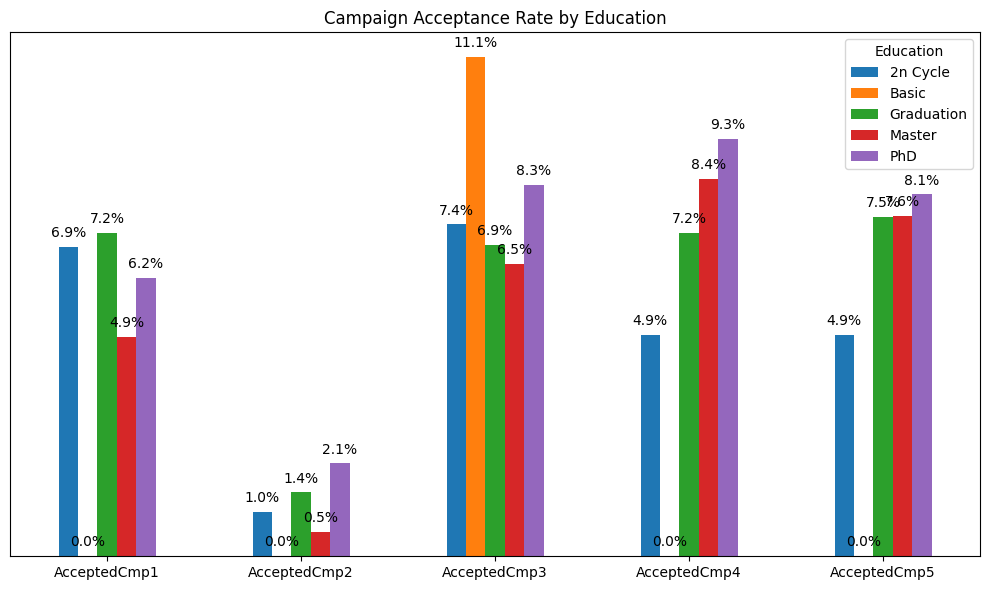

In [15]:
# Group by 'InHouse' and calculate the acceptance rate for each campaign
campaign_acceptance = df.groupby('Education')[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].mean() * 100

# Transpose the DataFrame for plotting
campaign_acceptance = campaign_acceptance.T

# Plotting the bar chart
ax = campaign_acceptance.plot(kind='bar', figsize=(10, 6))
plt.title('Campaign Acceptance Rate by Education')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
ax.tick_params(axis='y', which='both', left=False, labelleft=False) # Hide y-axis ticks and labels
plt.legend(title='Education', loc='upper right')

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

> Deals Purchased by Marital Status
___

In [16]:
# Perform the groupby and aggregation
purchases = df.groupby(['Marital_Status'])[['TotalPurchases', 'NumDealsPurchases']].agg(['sum']).reset_index()

# Flatten the multi-level columns by removing the second level
purchases.columns = [col[0] for col in purchases.columns]

# Now `purchases` will have only "TotalPurchases" and "NumDealsPurchases" as column names
purchases["% DealsPurchases"] = round((purchases["NumDealsPurchases"] / purchases["TotalPurchases"]) * 100, 1)
purchases

,Marital_Status,TotalPurchases,NumDealsPurchases,% DealsPurchases
0,Divorced,3535,565,16.0
1,Married,12922,2067,16.0
2,Single,6877,1034,15.0
3,Together,8594,1348,15.7
4,Widow,1286,180,14.0


> Deals Purchased by Education
___

In [17]:
# Perform the groupby and aggregation
purchases = df.groupby(['Education'])[['TotalPurchases', 'NumDealsPurchases']].agg(['sum']).reset_index()

# Flatten the multi-level columns by removing the second level
purchases.columns = [col[0] for col in purchases.columns]

# Now `purchases` will have only "TotalPurchases" and "NumDealsPurchases" as column names
purchases["% DealsPurchases"] = round((purchases["NumDealsPurchases"] / purchases["TotalPurchases"]) * 100, 1)
purchases

,Education,TotalPurchases,NumDealsPurchases,% DealsPurchases
0,2n Cycle,2802,456,16.3
1,Basic,379,97,25.6
2,Graduation,16872,2602,15.4
3,Master,5506,895,16.3
4,PhD,7655,1144,14.9


> Spending by Marital Status
___

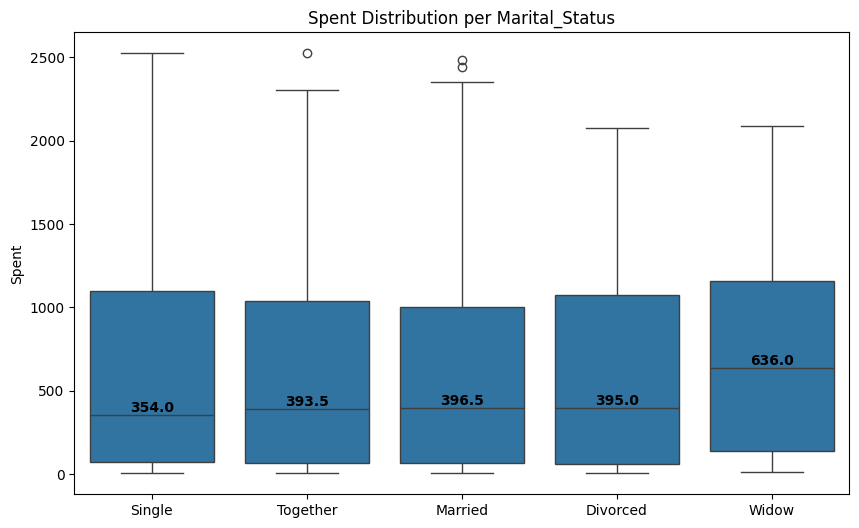

In [18]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='Marital_Status', y='Spent', data=df)

# Calculate the median (50th percentile) for each group and overlay it
medians = df.groupby('Marital_Status')['Spent'].median()

# Get the x-axis category order directly from the plot
category_order = df['Marital_Status'].unique()

# Add the median values as text annotations on the plot
for i, category in enumerate(category_order):
    median = medians[category]  # Get the median for the correct category
    plt.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black', fontsize=10, weight='bold')

# Add plot labels and title
plt.title('Spent Distribution per Marital_Status')
plt.xlabel('')
plt.ylabel('Spent')
plt.show()

> Spending by Education
___

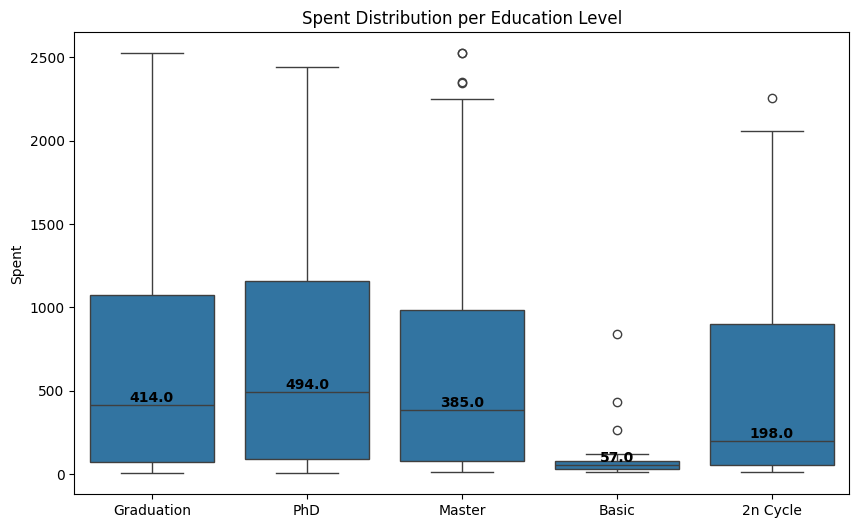

In [19]:
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='Education', y='Spent', data=df)

# Calculate the median values for each Education group
medians = df.groupby('Education')['Spent'].median()

# Get the x-axis category order directly from the plot
category_order = df['Education'].unique()

# Add the median values as text annotations on the plot
for i, category in enumerate(category_order):
    median = medians[category]  # Get the median for the correct category
    plt.text(i, median, f'{median:.1f}', ha='center', va='bottom', color='black', fontsize=10, weight='bold')

plt.title('Spent Distribution per Education Level')
plt.xlabel('')
plt.ylabel('Spent')
plt.show()


> Response x Income
___

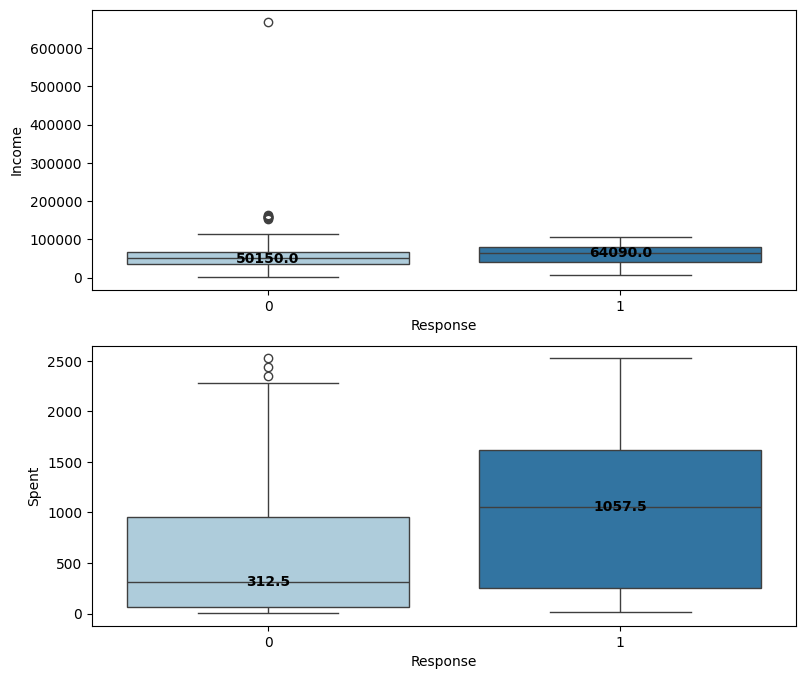

In [20]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,2)

sns.boxplot(x='Response', y='Income', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,0]))
medians = df.groupby('Response')['Income'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='Spent', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,0]))
medians = df.groupby('Response')['Spent'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

> Response x Amount Spent
---

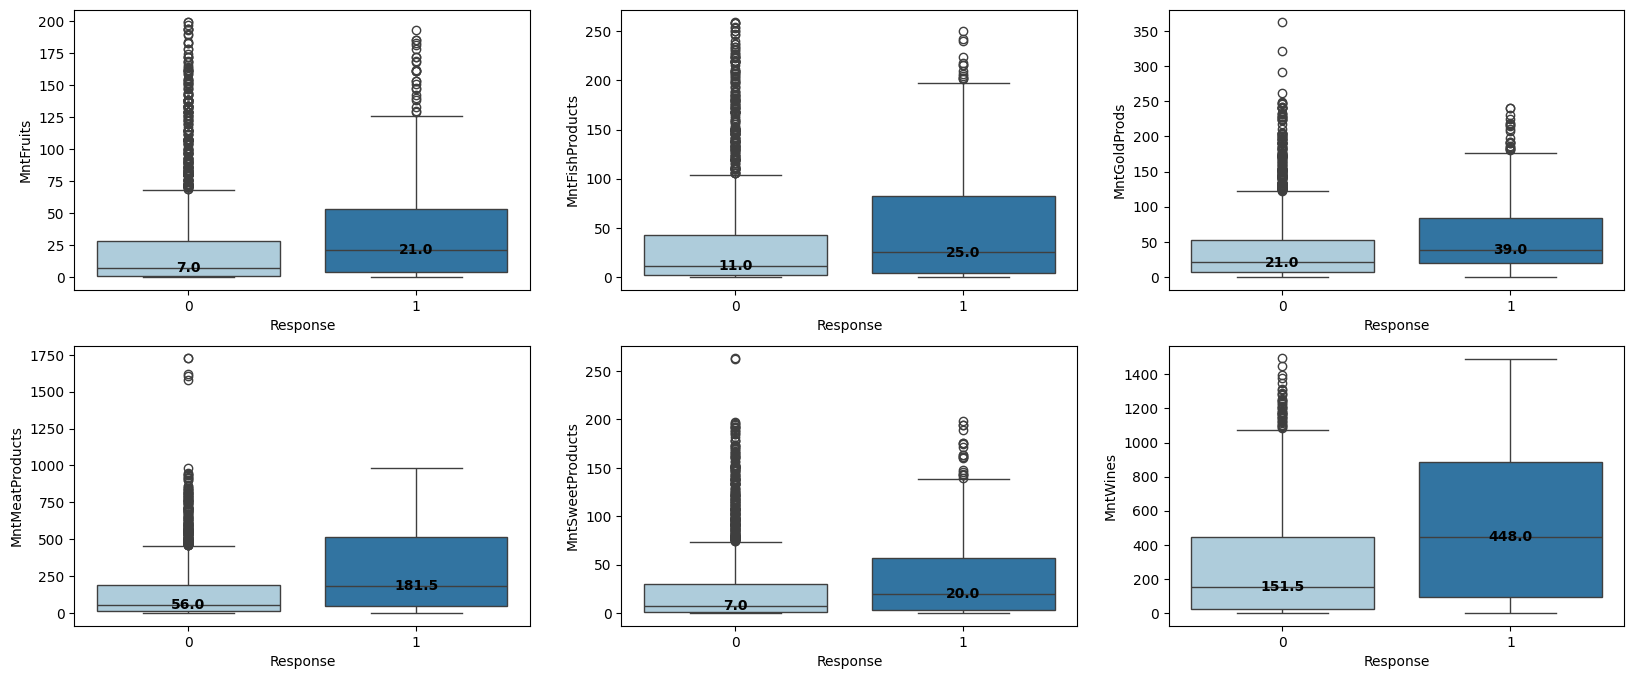

In [21]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)

sns.boxplot(x='Response', y='MntFruits', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,0]))
# Calculate the median (50th percentile) for each group and overlay it
medians = df.groupby('Response')['MntFruits'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='MntFishProducts', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,1]))
medians = df.groupby('Response')['MntFishProducts'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='MntGoldProds', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,2]))
medians = df.groupby('Response')['MntGoldProds'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='MntMeatProducts', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,0]))
medians = df.groupby('Response')['MntMeatProducts'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='MntSweetProducts', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,1]))
medians = df.groupby('Response')['MntSweetProducts'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='MntWines', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,2]))
medians = df.groupby('Response')['MntWines'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

> Response x 'NumDealsPurchases' | 'NumWebPurchases' | NumWebVisitsMonth | 'NumCatalogPurchases' | 'NumStorePurchases'
---

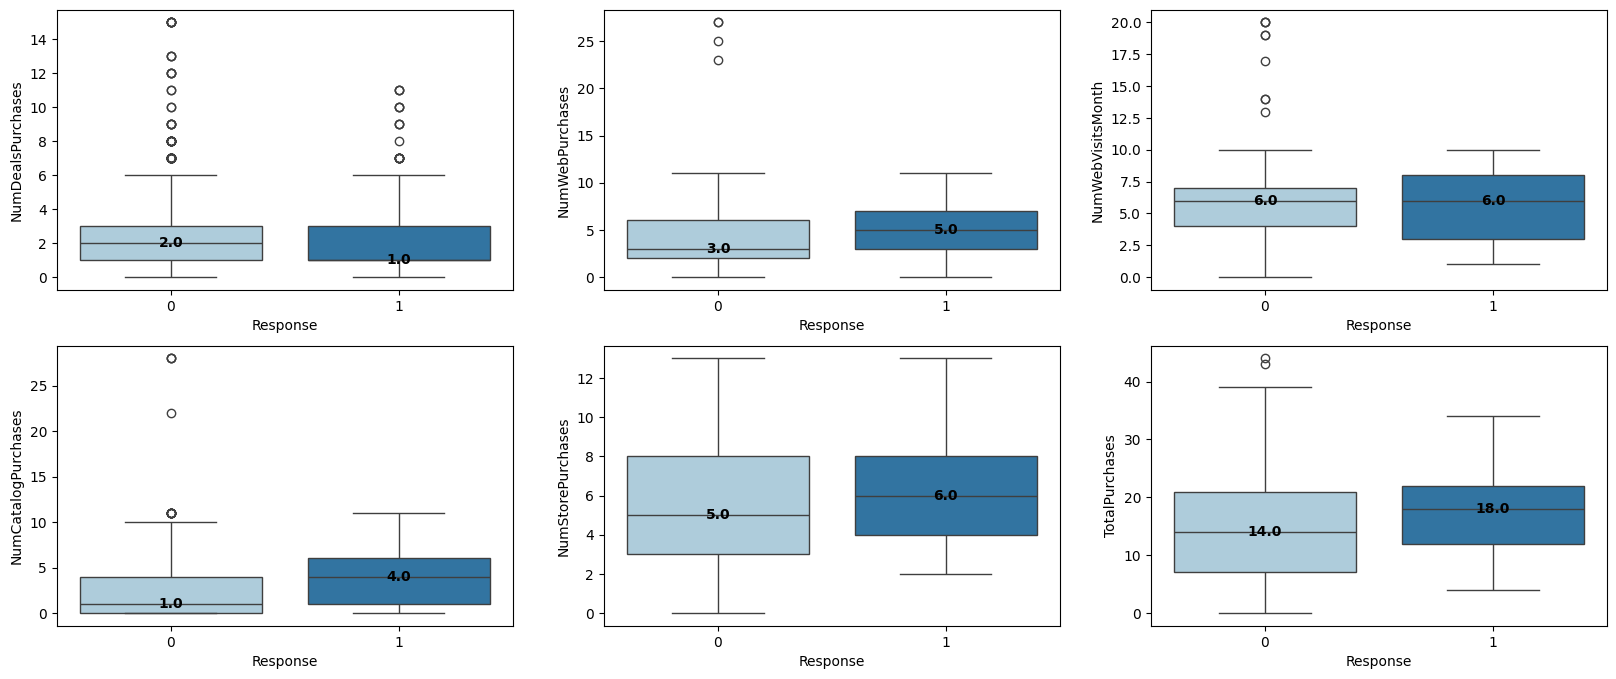

In [22]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)

sns.boxplot(x='Response', y='NumDealsPurchases', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,0]))
medians = df.groupby('Response')['NumDealsPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='NumWebPurchases', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,1]))
medians = df.groupby('Response')['NumWebPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='NumWebVisitsMonth', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[0,2]))
medians = df.groupby('Response')['NumWebVisitsMonth'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='NumCatalogPurchases', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,0]))
medians = df.groupby('Response')['NumCatalogPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='NumStorePurchases', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,1]))
medians = df.groupby('Response')['NumStorePurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Response', y='TotalPurchases', data=df, palette="Paired", hue='Response', legend=False, ax=fig.add_subplot(gs[1,2]))
medians = df.groupby('Response')['TotalPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

# 2. Data Preparation and Cleaning for Customer Segmentation

> **Interquartile Range (IQR)**

* IQR to be more robust since outliers are not included in the calculation of percentiles.

  Outliers are typically defined as values below

  *  Q1 - 1.5 x IQR

    or above
  * Q3 + 1.5 x IQR

  where Q1 = First Quartil (25%), Q3 = Third Quartil (75%) and IQR = Q3 - Q1

> Statiscal Table and Interquartile Range (IQR)
---



In [23]:
# Builting the statistical table and other indicators to check for outliers

df_describe = df.describe().T.round(1)
df_describe["IQR"] = df_describe["75%"] - df_describe["25%"] # defining IQR
df_describe["BotOutlier"] = df_describe["25%"] - 1.5*df_describe["IQR"] # determining cutoff for Bottom outliers
df_describe["TopOutlier"] = df_describe["75%"] + 1.5*df_describe["IQR"] # determining cutoff for Top outliers
df_describe['CheckBotOut'] = df_describe.apply(lambda row: 'Yes' if row['min'] < row["BotOutlier"] else 'No', axis=1) # mark for possible Bottom outliers
df_describe['CheckTopOut'] = df_describe.apply(lambda row: 'Yes' if row['max'] > row["TopOutlier"] else 'No', axis=1) # mark for possible Top outliers
df_describe

,count,mean,min,25%,50%,75%,max,std,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
ID,2236.0,5591.551878,0.0,2828.25,5458.5,8427.75,11191.0,3245.240106,5599.5,-5571.0,16827.0,No,No
Year_Birth,2236.0,1968.796512,1893.0,1959.0,1970.0,1977.0,1996.0,11.980604,18.0,1932.0,2004.0,Yes,No
Income,2212.0,52232.51085,1730.0,35233.5,51381.5,68522.0,666666.0,25187.455359,33288.5,-14699.25,118454.75,No,Yes
Kidhome,2236.0,0.444991,0.0,0.0,0.0,1.0,2.0,0.538551,1.0,-1.5,2.5,No,No
Teenhome,2236.0,0.506261,0.0,0.0,0.0,1.0,2.0,0.544615,1.0,-1.5,2.5,No,No
Dt_Customer,2236,2013-07-10 15:56:21.037566976,2012-07-30 00:00:00,2013-01-17 00:00:00,2013-07-09 00:00:00,2013-12-30 06:00:00,2014-06-29 00:00:00,NaN,347 days 06:00:00,2011-08-15 03:00:00,2015-06-04 03:00:00,No,No
Recency,2236.0,49.147138,0.0,24.0,49.0,74.0,99.0,28.95488,50.0,-51.0,149.0,No,No
MntWines,2236.0,303.873435,0.0,23.0,173.0,505.0,1493.0,336.876776,482.0,-700.0,1228.0,No,Yes
MntFruits,2236.0,26.27102,0.0,1.0,8.0,33.0,199.0,39.761356,32.0,-47.0,81.0,No,Yes
MntMeatProducts,2236.0,166.924419,0.0,16.0,67.0,232.0,1725.0,225.77855,216.0,-308.0,556.0,No,Yes


> Defining Functions to Remove Outliers
---
We will create functions to remove outliers and plot box plots to compare distributions. The comparison will include box plots with outliers included and box plots with outliers removed.

---
For remove_outliers function, the multiplier will depend on the distribution of the variable. For variables with a normal distribution, we can use lower multipliers, such as the commonly used 1.5. However, for variables that do not follow a normal distribution and exhibit long tails with extreme values that appear relevant, we will adopt a less conservative approach by using higher multipliers. This adjustment allows the algorithm to expand the cutoff for these variables.

In [24]:
### Function to remove outliers
def remove_outliers(df, column, multiplier):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out rows that have column within the bounds
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_no_outliers

### Function to plot boxplot
def plot_boxplot(ax, data, x, y, y_label, title):
    sns.boxplot(data=data, x=x, y=y, ax=ax)
    ax.set_ylabel(y_label)
    ax.set_title(title)

### Function to compare the two boxplots
def compare_boxplot(df, x, y, multiplier):
    # Create a figure with two subplots in a 1x2 layout
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot the first boxplot with outliers
    plot_boxplot(axes[0], df, x=x, y=y, y_label=y, title="With Outliers")
    # Add shape information to the first plot
    axes[0].text(0.95, 0.95, f"Shape: {df.shape}",
                 transform=axes[0].transAxes, ha='right', va='top', fontsize=10, color="gray")

    # Removing outliers
    df_no_outliers = remove_outliers(df, y, multiplier)

    # Plot the second boxplot without outliers
    plot_boxplot(axes[1], df_no_outliers, x=x, y=y, y_label=y, title="Without Outliers")
    # Add shape information to the second plot
    axes[1].text(0.95, 0.95, f"Shape: {df_no_outliers.shape}",
                 transform=axes[1].transAxes, ha='right', va='top', fontsize=10, color="gray")

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Return the shapes of both dataframes for further analysis
    return df_no_outliers, df.shape, df_no_outliers.shape

> Funcion to plot histograms
---

In [25]:
### Function to easily plot histogram for variables
def plot_hist(df, x):
    # Create a figure with a single subplot
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(2,3)

    # Get the axes object using add_subplot and then call the hist method on it
    ax = fig.add_subplot(gs[0,0])
    ax.hist(df[x], bins=30, color='skyblue', edgecolor='black') # Use ax.hist

    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {x}')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

> Year_Birth
---

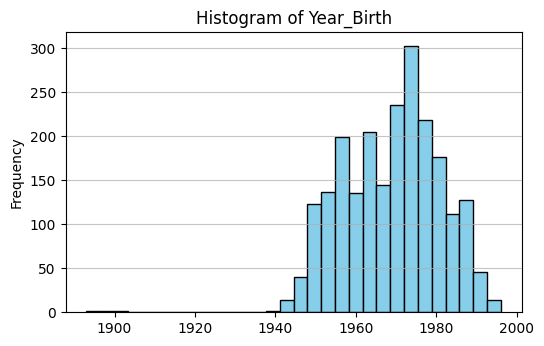

In [26]:
plot_hist(df, x="Year_Birth")

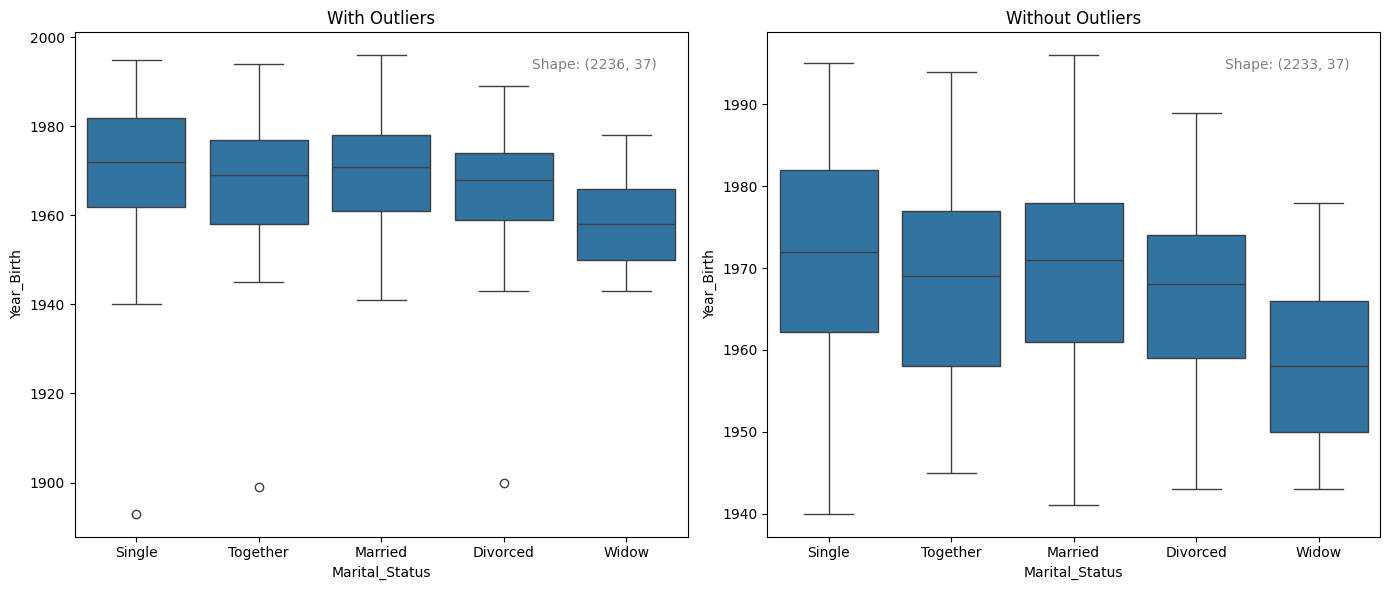

After removing outliers, we lost -0.1% of our data.


In [27]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="Year_Birth", multiplier=1.5)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> Income
---

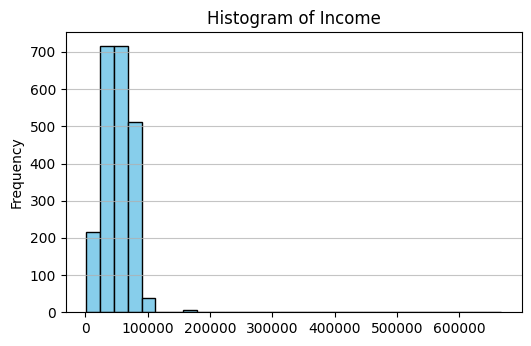

In [28]:
plot_hist(df, x="Income")

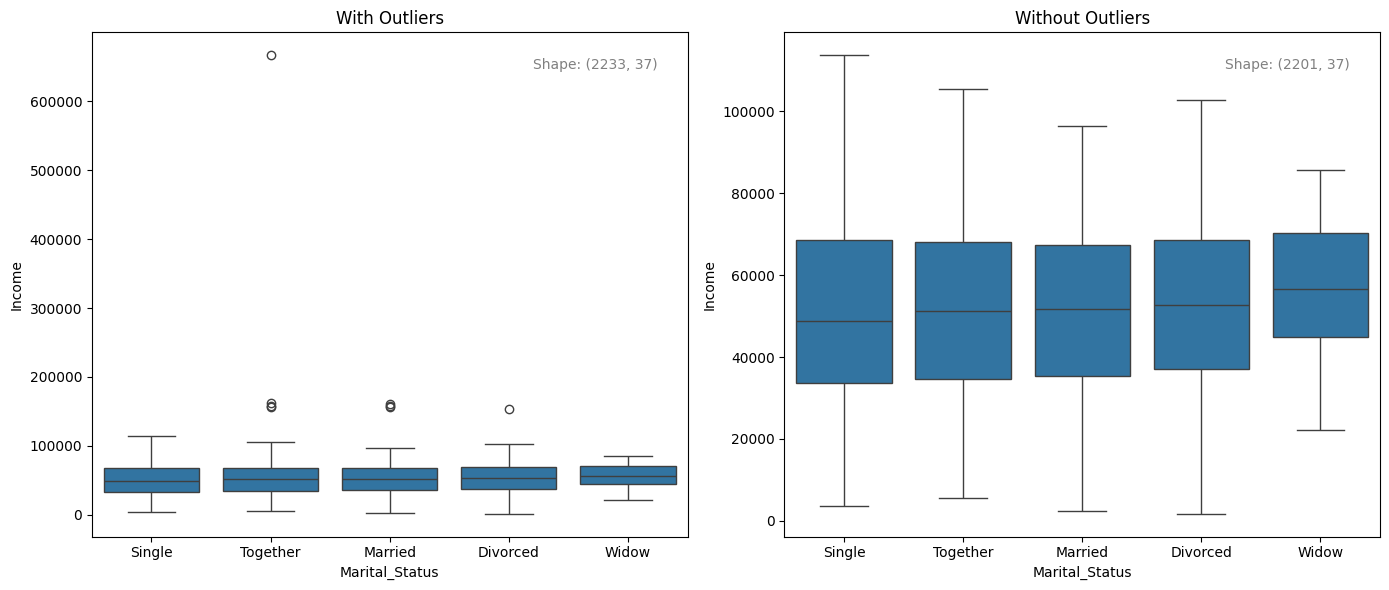

After removing outliers, we lost -1.4% of our data.


In [29]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="Income", multiplier=1.5)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> NumWebPurchases
---

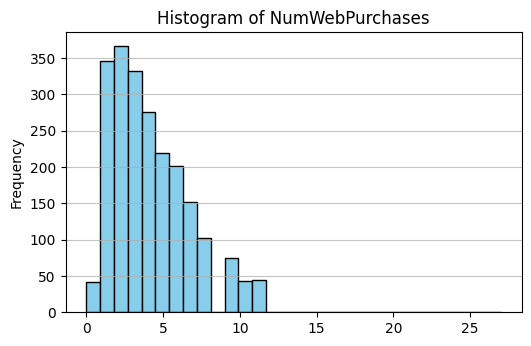

In [30]:
plot_hist(df, x="NumWebPurchases")

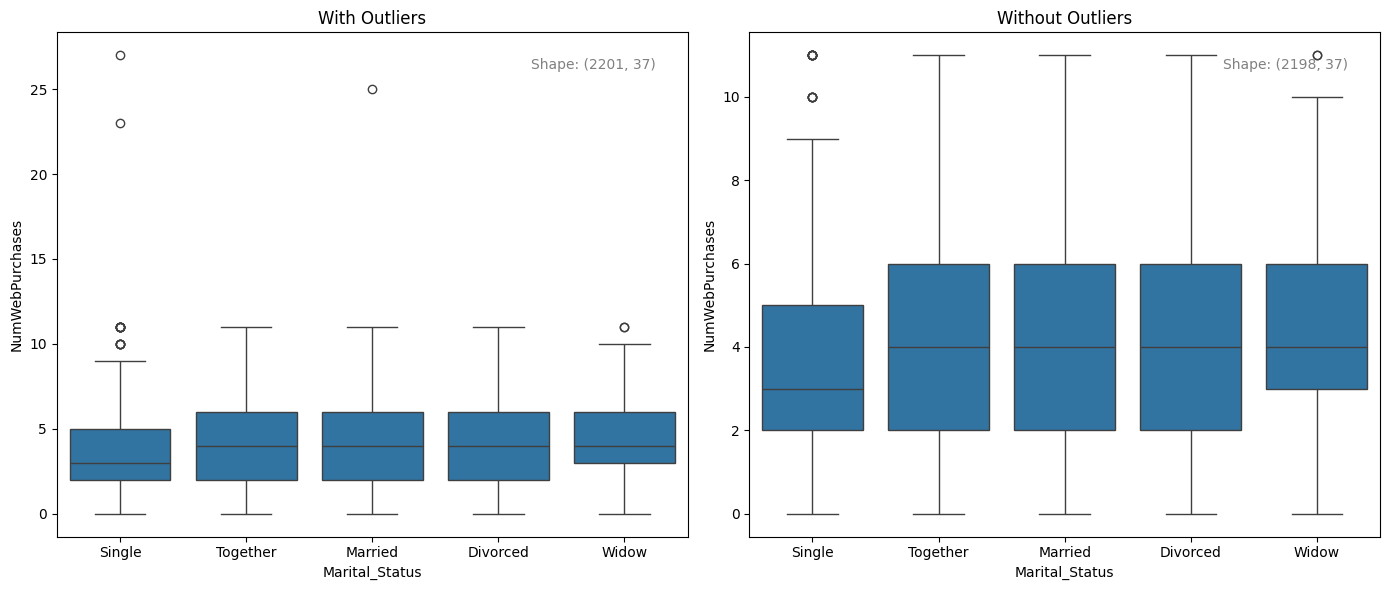

After removing outliers, we lost -0.1% of our data.


In [31]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="NumWebPurchases", multiplier = 1.5)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntSweetProducts
---

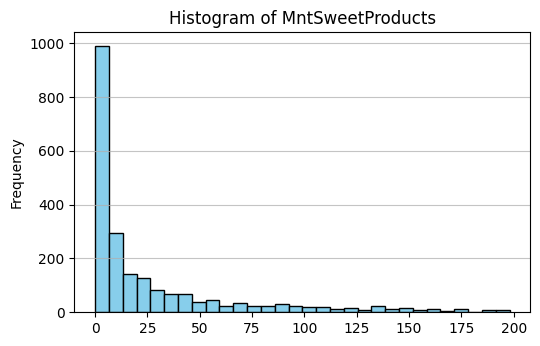

In [32]:
plot_hist(df, x="MntSweetProducts")

---
In cases where we have a long tail, we need to adopt a less conservative approach and set a higher multiplier. This adjustment helps to avoid dropping important values that exist in the tail of the distribution.

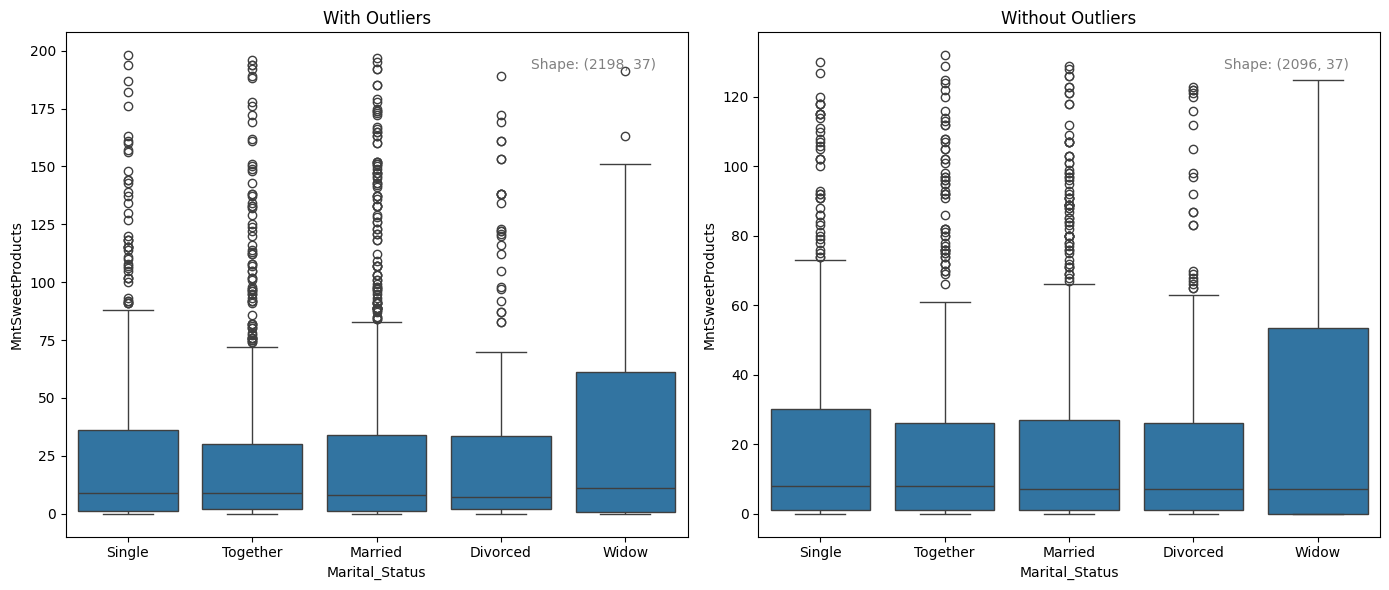

After removing outliers, we lost -4.6% of our data.


In [33]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntSweetProducts", multiplier=3.0)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntWines
---

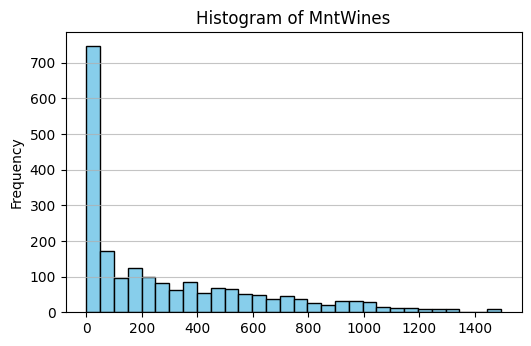

In [34]:
plot_hist(df, x="MntWines")

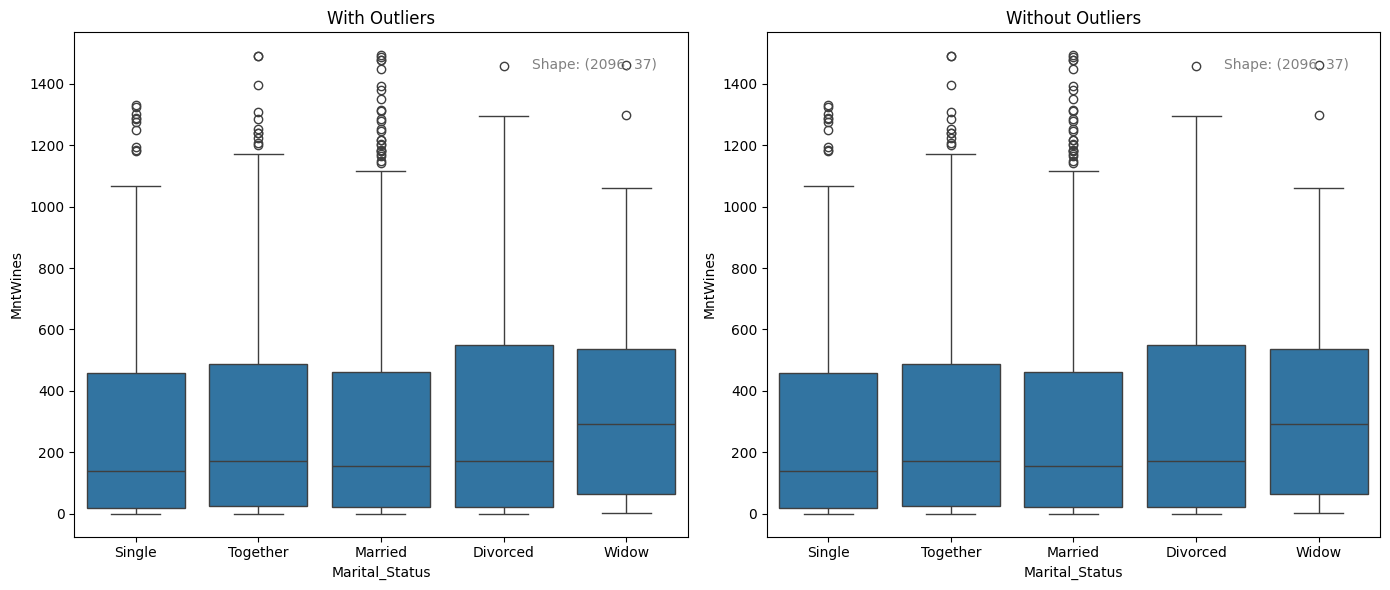

After removing outliers, we lost 0.0% of our data.


In [35]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntWines", multiplier=3.0)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntFruits
---

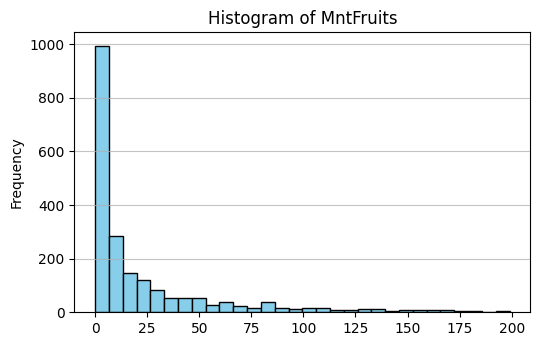

In [36]:
plot_hist(df, x="MntFruits")

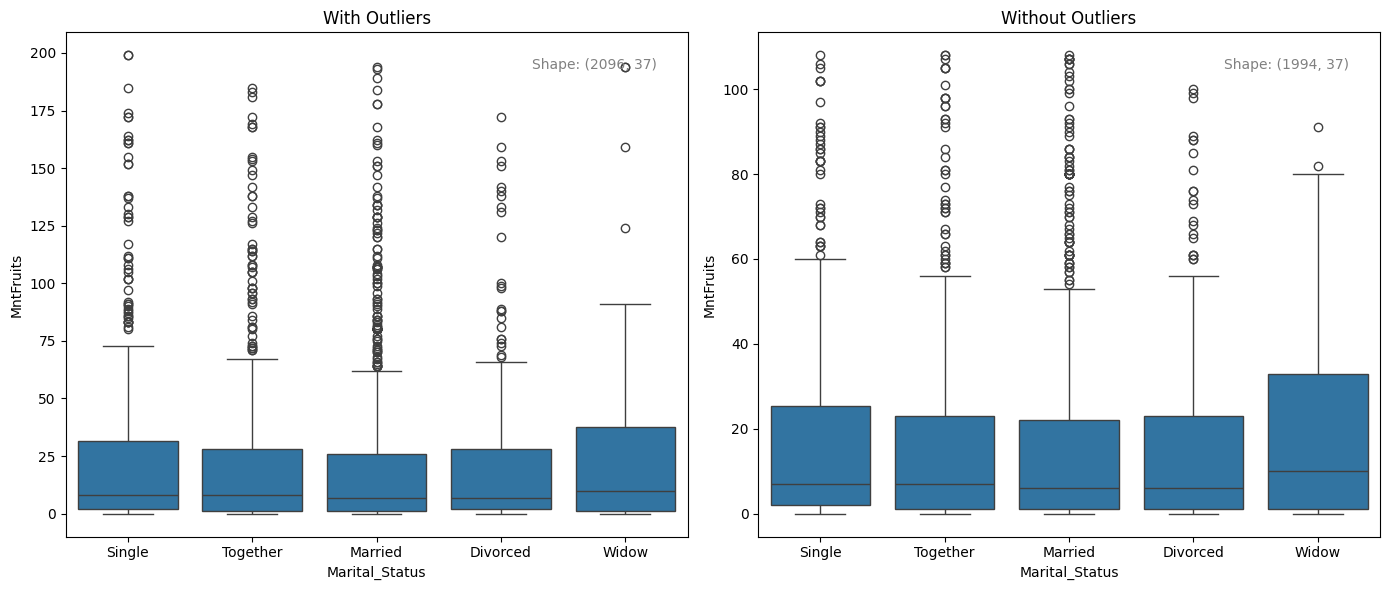

After removing outliers, we lost -4.9% of our data.


In [37]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntFruits", multiplier=3.0)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntMeatProducts
---

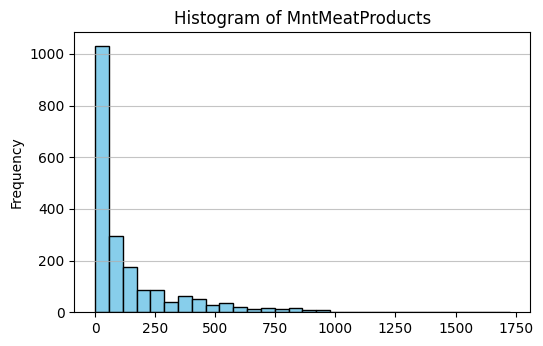

In [38]:
plot_hist(df, x="MntMeatProducts")

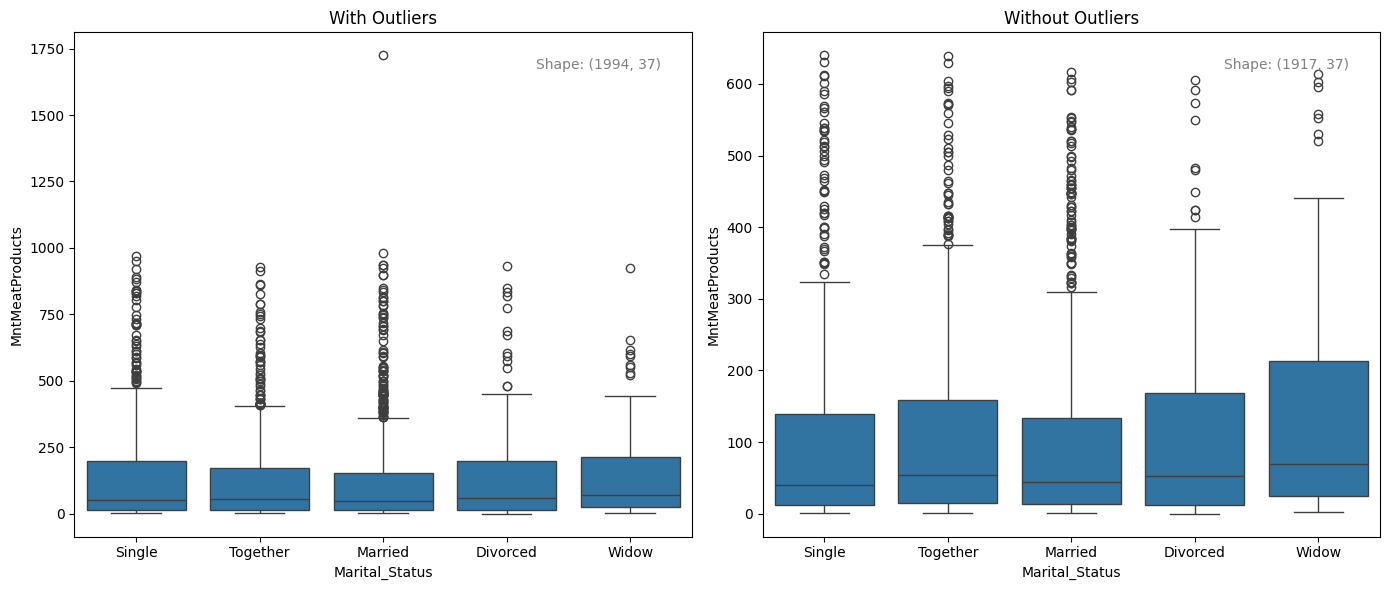

After removing outliers, we lost -3.9% of our data.


In [39]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntMeatProducts", multiplier=3)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntFishProducts
---

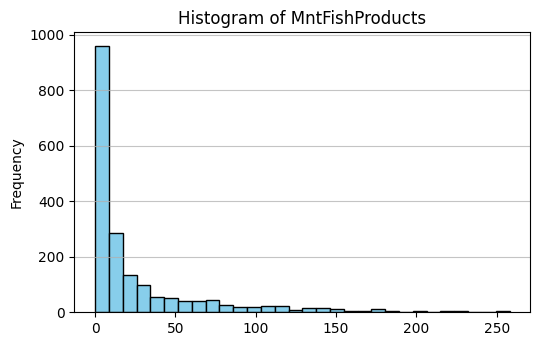

In [40]:
plot_hist(df, x="MntFishProducts")

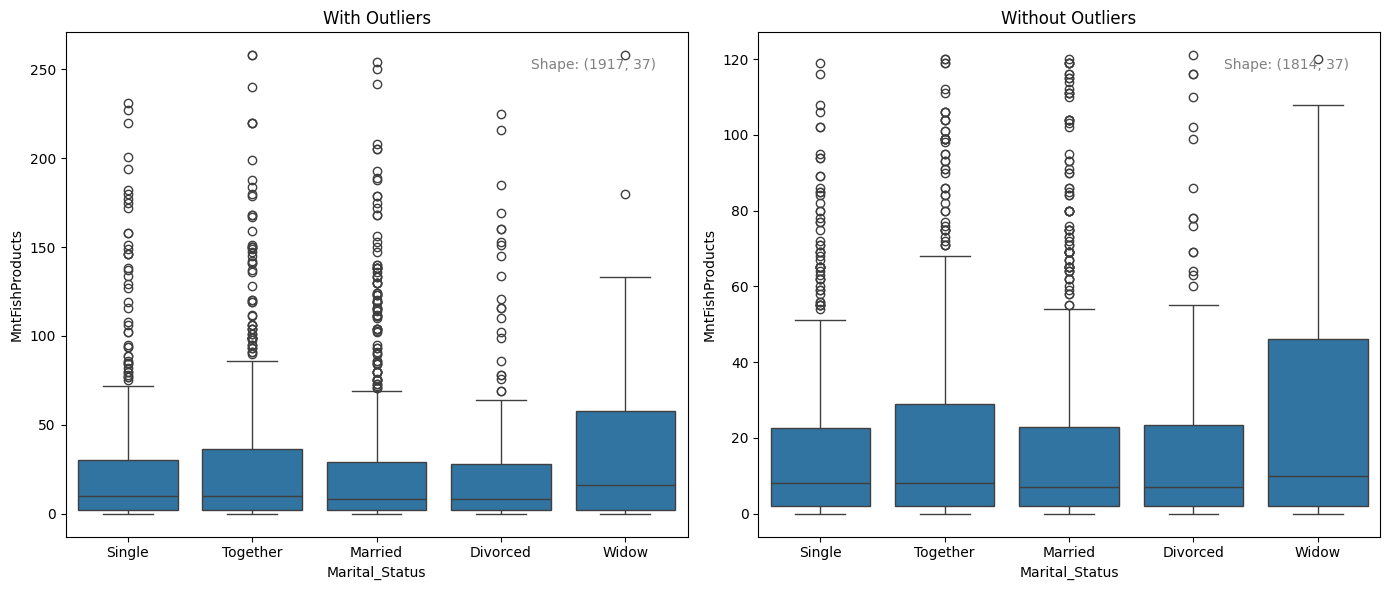

After removing outliers, we lost -5.4% of our data.


In [41]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntFishProducts", multiplier=3.0)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

> MntGoldProds
---

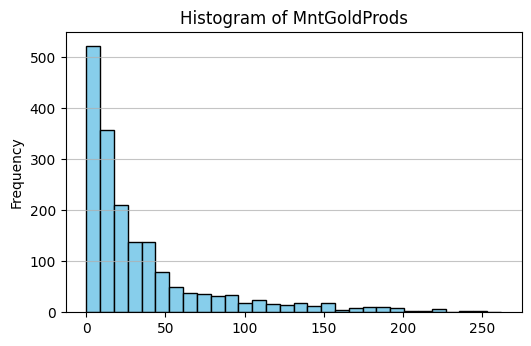

In [42]:
plot_hist(df, x="MntGoldProds")

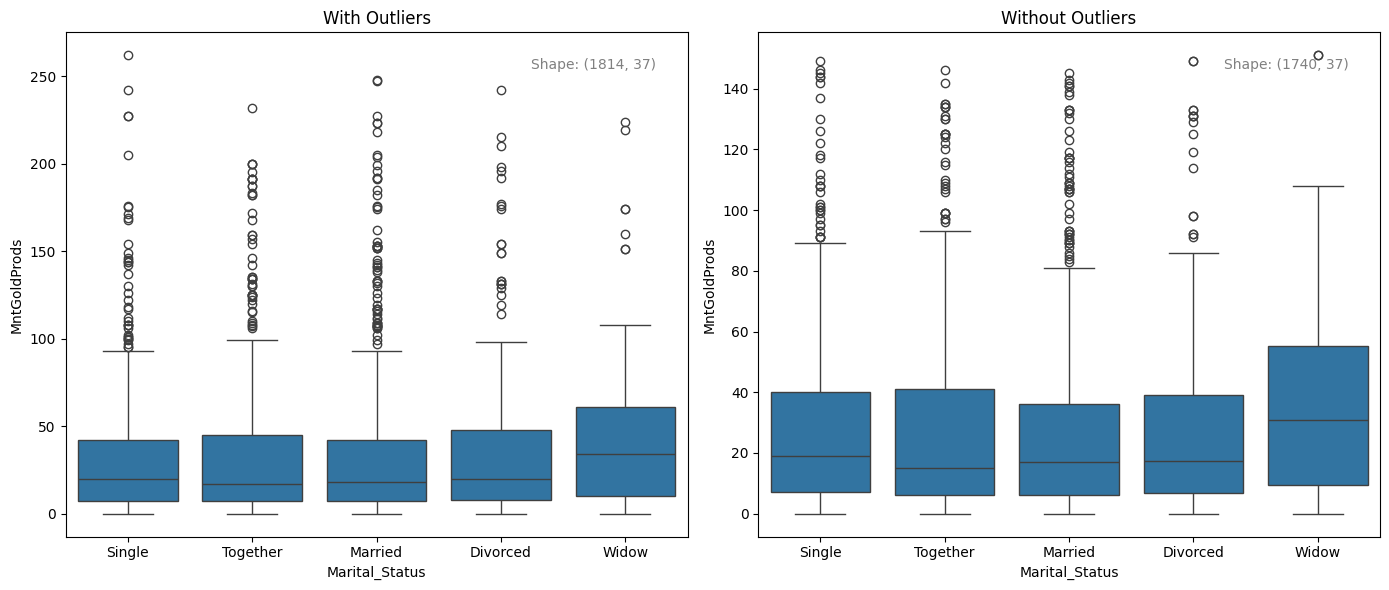

After removing outliers, we lost -4.1% of our data.


In [43]:
df, original_shape, no_outliers_shape = compare_boxplot(df, x="Marital_Status", y="MntGoldProds", multiplier=3.0)

# Operation on the shape relation
shape_difference = round((no_outliers_shape[0]/original_shape[0]-1)*100, 1)
print("After removing outliers, we lost {0}% of our data.".format(shape_difference))

In [44]:
1740/2240

0.7767857142857143

# 3. Clustering Algorithm

> Reseting the index for the cleaned dataframe

In [45]:
df = df.reset_index(drop=True)

In [46]:
df_num = df.drop(columns = ['NumCatalogPurchases', 'MntWines', 'ID', 'Year_Birth', 'Education', 'Marital_Status', 'Dt_Customer',
                            'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                            'Complain', 'Response', 'InHouse', 'Year_Customer', 'EducationLevel', 'HasChildren',
                            'TotalCampaignsAccepted', 'Spent', 'TotalPurchases', 'AverageSpend'])

> Correlation Matrix

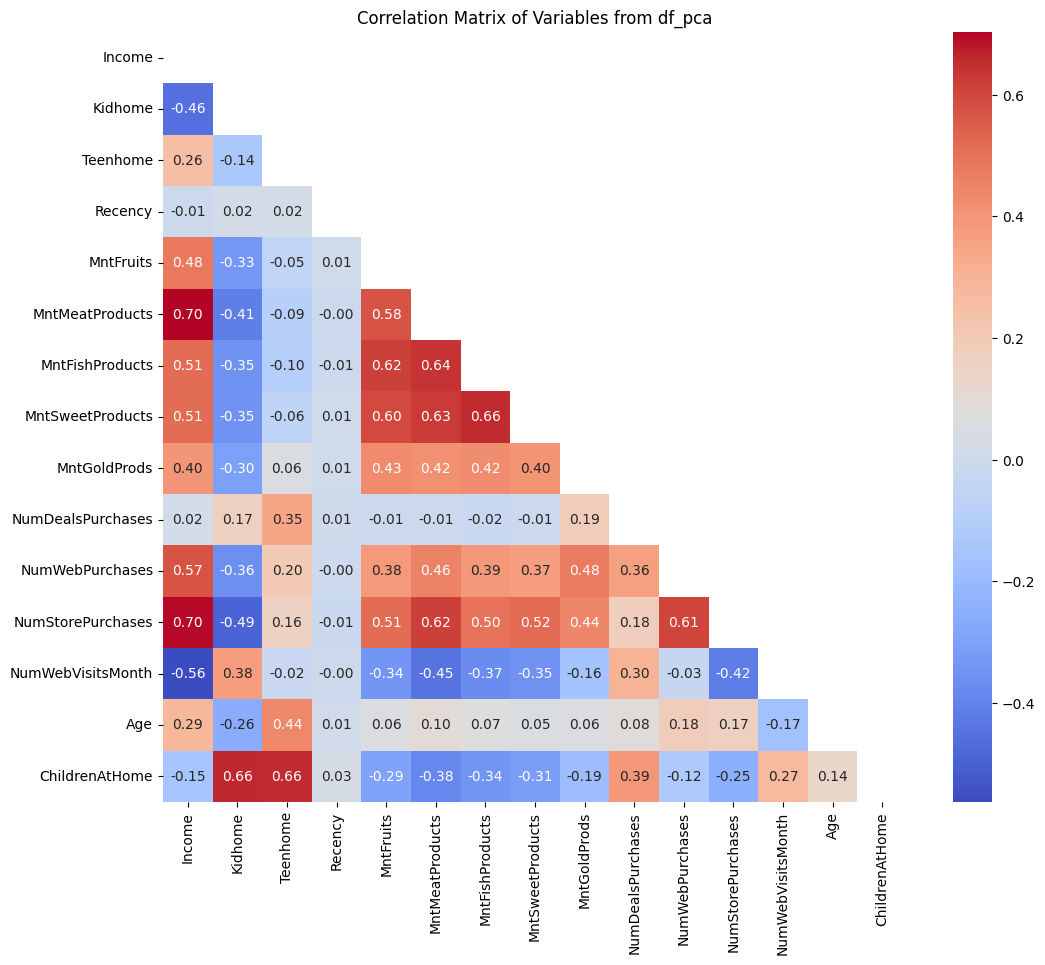

In [47]:
# Calculate the correlation matrix
corr_matrix = df_num.corr()

# Create a mask for the off-diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Variables from df_pca')
plt.show()

> Dropping KidHome and TeenHome and non numerical variables
---
As observed in the matrix above, KidHome has a significant negative correlation with almost all other features, unlike TeenHome. To capture more variability from both variables, we created a new variable called ChildrenAtHome, which combines the two.

In [48]:
df_num = df_num.drop(columns = ['Kidhome', 'Teenhome'])

> Correlation Matrix
---

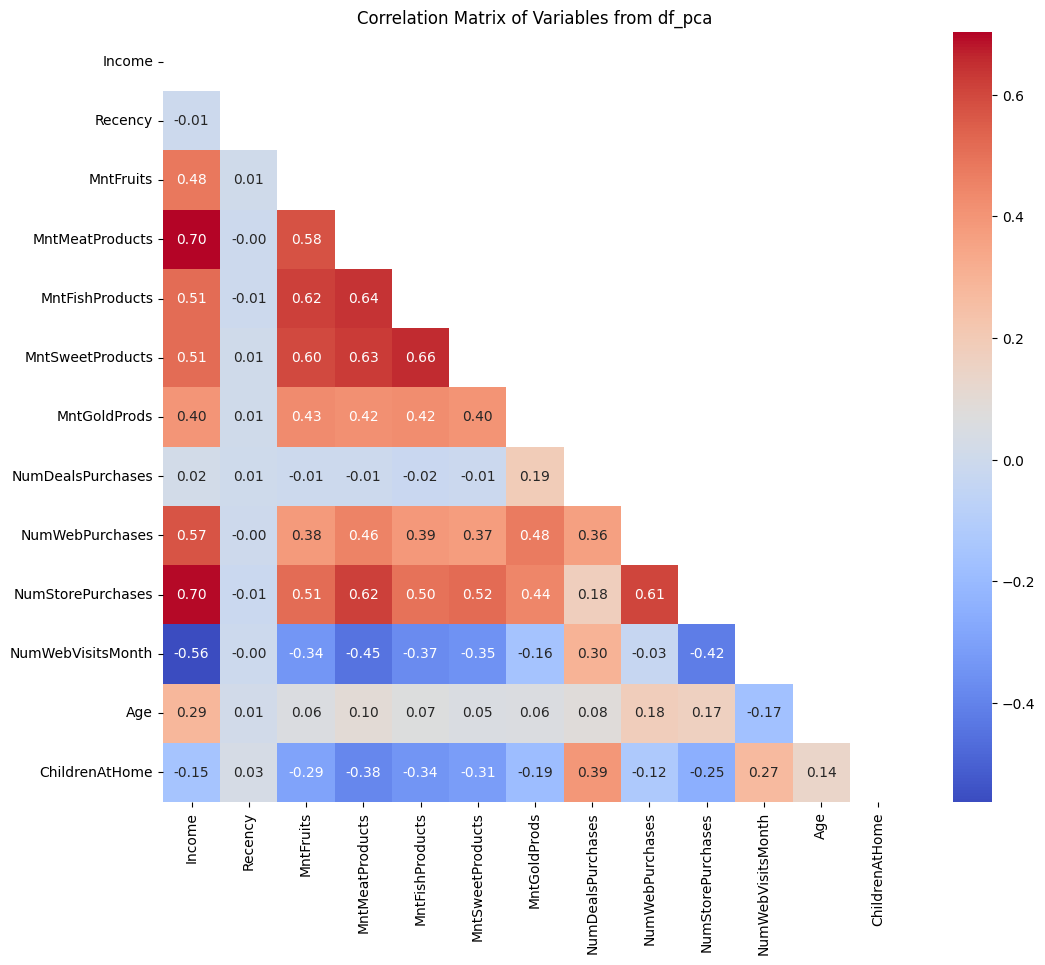

In [49]:
# Calculate the correlation matrix
corr_matrix = df_num.corr()

# Create a mask for the off-diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Variables from df_pca')
plt.show()

> Performing Principal Component Analysis
---
The key concept of PCA is to reduce the dimensionality of the original dataset, selecting a smaller number of components. It only takes into account the most important components based on their degree of explanation for the process.

For a detailed overview of the process, please see my post on Medium: [Clustering and Principal Component Analysis (PCA) from Sklearn](https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648)


In [50]:
df_pca = df_num

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pcascale = StandardScaler()
std_values = pd.DataFrame(pcascale.fit_transform(df_pca), columns=df_pca.columns)
pca = PCA()
pca.fit(std_values)

PCA()

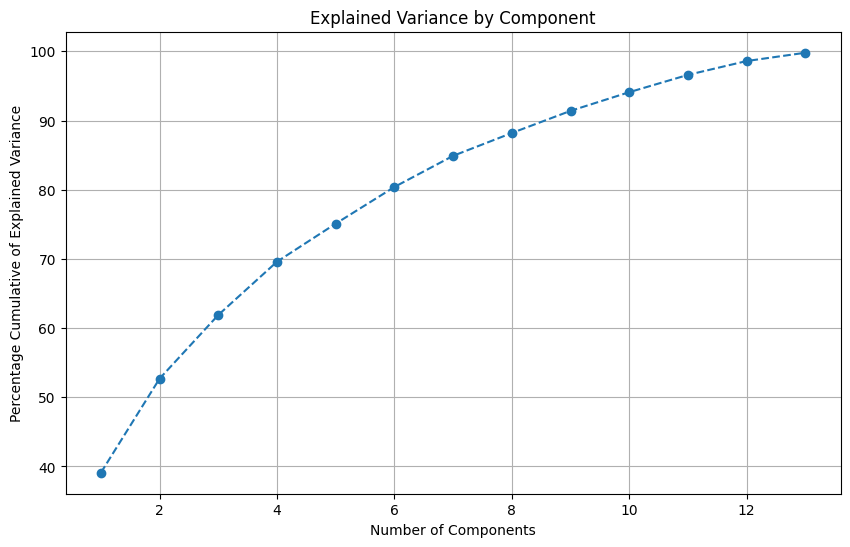

In [52]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

plt.figure(figsize = (10,6))

plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")

plt.grid()

plt.ylabel("Percentage Cumulative of Explained Variance")
plt.xlabel("Number of Components")
plt.title("Explained Variance by Component")
plt.show()

---
We can see from plot of the cumulative variance ratio, that it's possible to retain almost 85% of the variation by using only 7 out of the 13 features. A number of features that preserves between 85-90% of the total variation is a good threshold, so for our example we will take the first 7 components.

In [53]:
pca_new = PCA(n_components = 7)
pca_new.fit(df_pca)
loadings = pd.DataFrame(pca_new.components_.T, columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'], index=df_pca.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Income,0.999987,-0.005083,-0.000375,0.000059,-0.000040,-0.000024,-0.000019
Recency,-0.000010,-0.000025,0.137470,0.990317,0.003859,-0.016685,-0.004902
MntFruits,0.000540,0.080470,0.243074,-0.026800,0.342840,0.225706,0.874420
MntMeatProducts,0.004926,0.980712,-0.151628,0.021545,-0.120397,-0.006208,0.001048
MntFishProducts,0.000742,0.122125,0.310777,-0.057999,0.625433,-0.682151,-0.168414
MntSweetProducts,0.000657,0.102817,0.243421,-0.025877,0.492421,0.693476,-0.451157
MntGoldProds,0.000697,0.076302,0.861460,-0.118123,-0.483342,-0.012998,-0.057609
NumDealsPurchases,0.000002,-0.000472,0.010334,-0.001185,-0.013011,-0.000022,-0.002957
NumWebPurchases,0.000080,0.002392,0.021202,-0.003032,-0.007022,-0.001125,0.002986
NumStorePurchases,0.000113,0.006058,0.016255,-0.003496,0.005256,0.010045,0.008706


As the Amount variables, are higlhy correlated, the algorithm "privilegies" it in counterpart of others variables, as seem above.
___

> Number of clusters
---
To decide on the number of clusters, we will run KMeans multiple times and apply the elbow method to determine the optimal number of clusters to employ.

**Elbow Method**: The Elbow Approach will help us to observe how the sum of the clusters’ variance decreases as the number of clusters increases. The main goal is to select a number of clusters from which the sum is smoothed, which implies that the clustering process has achieved some form of stability

In [54]:
scores_pca = pca_new.transform(std_values)

In [55]:
from sklearn.cluster import KMeans

In [56]:
WCSS = []

for i in range(1,30):
  kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
  kmeans_pca.fit(scores_pca)
  WCSS.append(kmeans_pca.inertia_)

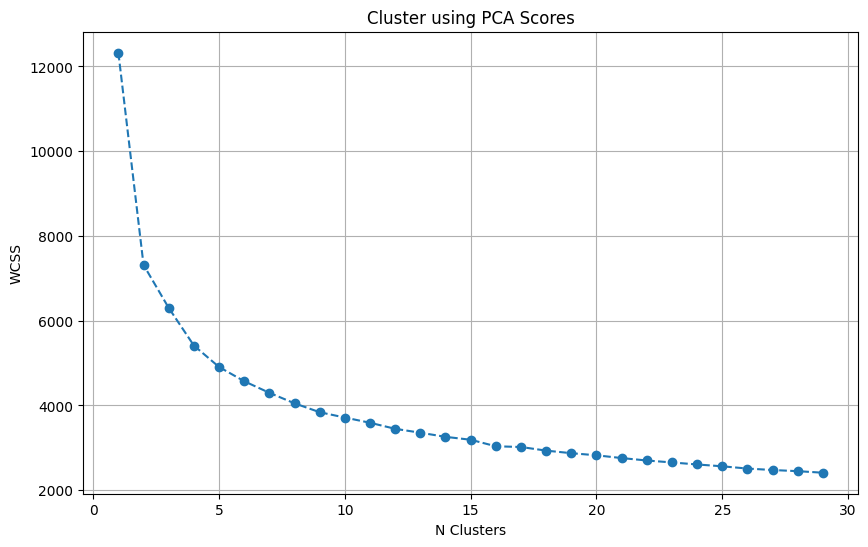

In [57]:
plt.figure(figsize = (10,6))
plt.plot(range(1,30), WCSS, marker = "o", linestyle = "--")
plt.grid()
plt.title("Cluster using PCA Scores")
plt.ylabel("WCSS")
plt.xlabel("N Clusters")
plt.show()

---
After performing the Elbow Method, we observe that using four clusters achieves a degree of stability in the process.

In [58]:
kmeans_pca = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

> Joining the PCA and cluster information to our original dataset.
---

In [59]:
# Concatening the original df with the components informations present in scores_pca.
df_clust_pca_kmeans = pd.concat([df, pd.DataFrame(scores_pca)], axis = 1)

# Renaming the column label from each component.
df_clust_pca_kmeans.columns.values[-7:] = ["Comp1", "Comp2", "Comp3", "Comp4", "Comp5", "Comp6", "Comp7"]

# Seting the cluster label to each observation, using the atribute .labels_
df_clust_pca_kmeans["Cluster"] = kmeans_pca.labels_

# Mapping each cluster segmentation and renaming their labels.
#df_clust_pca_kmeans["Cluster"] = df_clust_pca_kmeans["segment_kmeans_pca"].map({0:"Cluster 1", 1:"Cluster 2", 2:"Cluster 3", 3:"Cluster 4"})

> Cluster Analysis
---

> Representativeness of each cluster

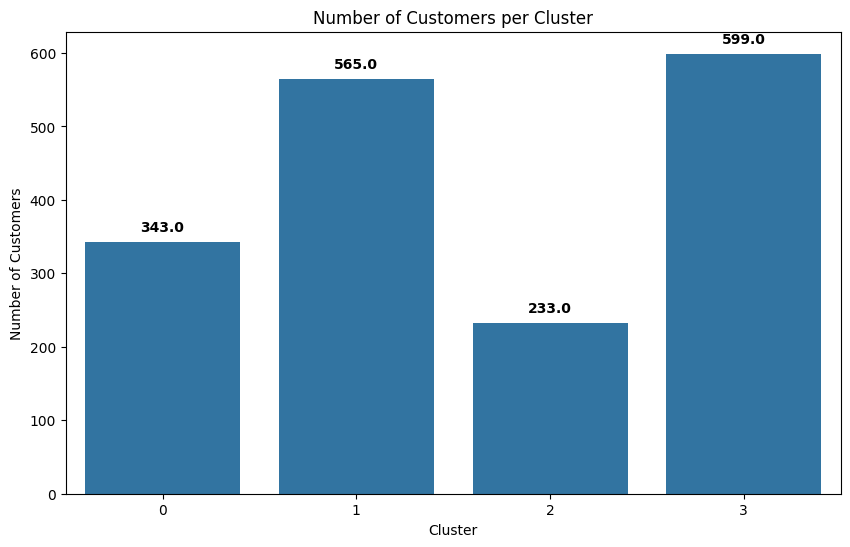

In [98]:
# Convert 'Cluster' column to categorical type
df_clust_pca_kmeans['Cluster'] = df_clust_pca_kmeans['Cluster'].astype('category')


fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot
sns.countplot(x='Cluster', data=df_clust_pca_kmeans, ax=ax)
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Customers")
ax.set_title("Number of Customers per Cluster")


# Add the counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, weight='bold')

plt.show()

> Income | Spent
---
* Cluster 2 has the highest expenses total. Following we have 0, 3 and 1

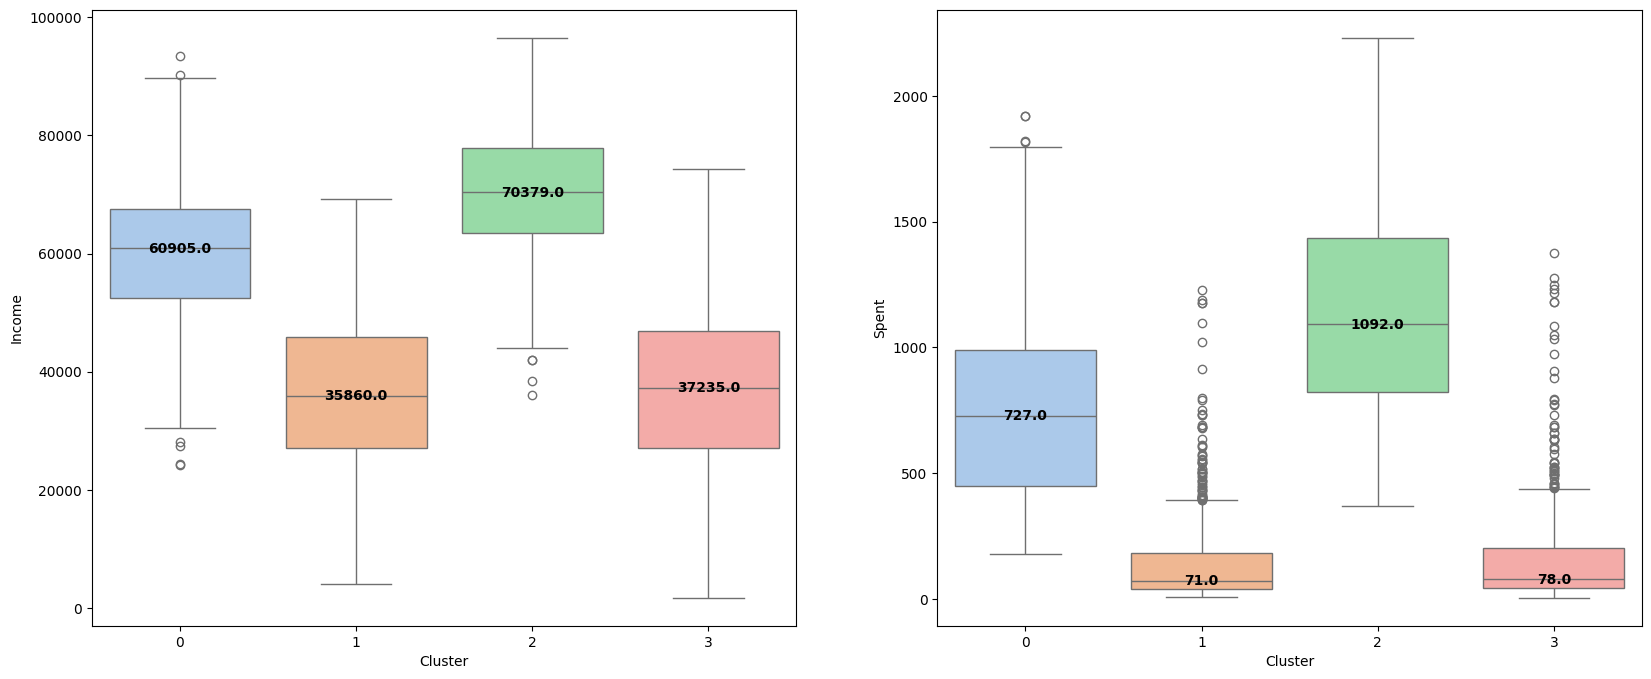

In [61]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)

sns.boxplot(x='Cluster', y='Income', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,0]))
medians = df_clust_pca_kmeans.groupby('Cluster')['Income'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='Spent', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,1]))
medians = df_clust_pca_kmeans.groupby('Cluster')['Spent'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

> Amount by Categories
---


* Cluster 2 has the most expenses in all categories, followed by cluster 0.




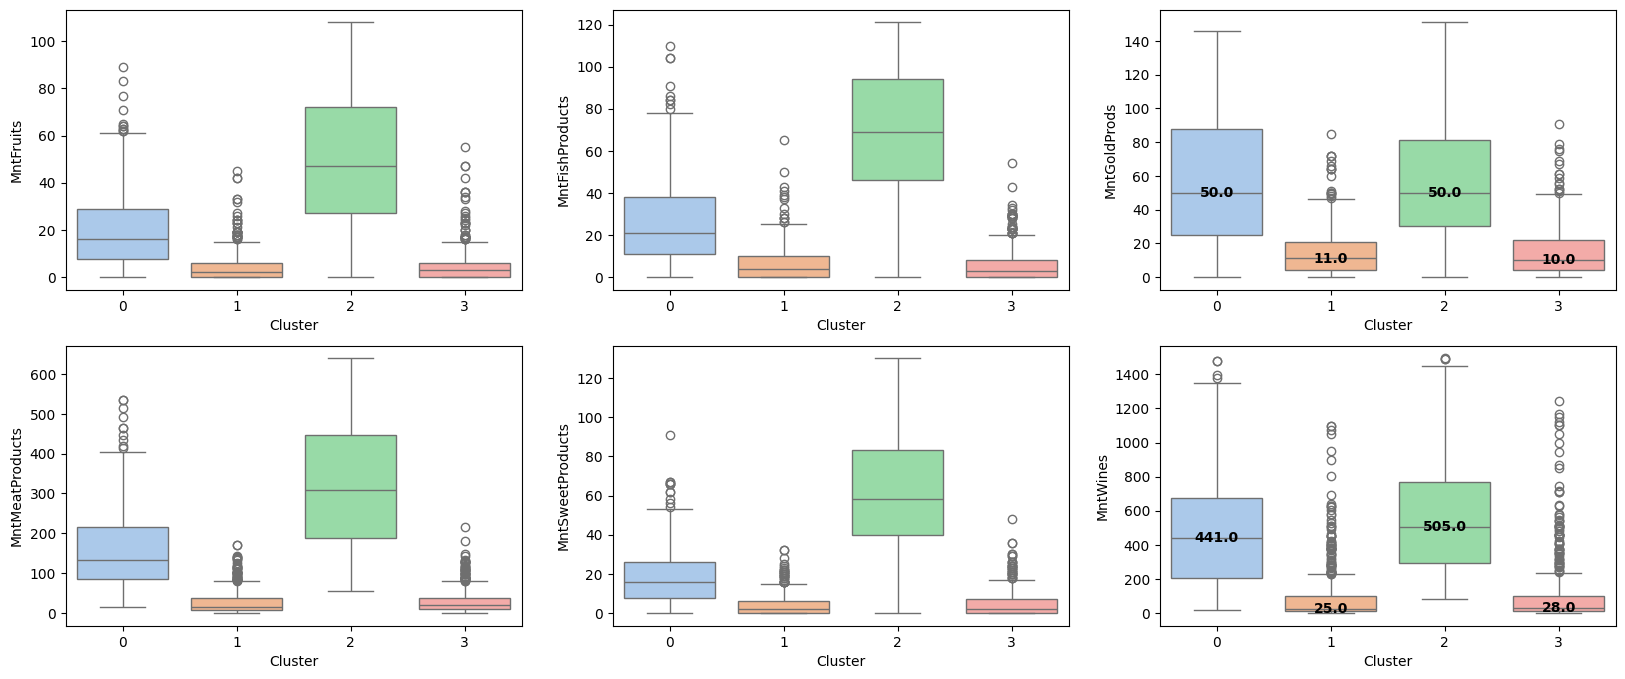

In [62]:
# total de gastos dos clientes

fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)

sns.boxplot(x='Cluster', y='MntFruits', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,0]))

sns.boxplot(x='Cluster', y='MntFishProducts', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,1]))

sns.boxplot(x='Cluster', y='MntGoldProds', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,2]))
# Calculate the median (50th percentile) for each group and overlay it
medians = df_clust_pca_kmeans.groupby('Cluster')['MntGoldProds'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='MntMeatProducts', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,0]))

sns.boxplot(x='Cluster', y='MntSweetProducts', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,1]))

sns.boxplot(x='Cluster', y='MntWines', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,2]))
medians = df_clust_pca_kmeans.groupby('Cluster')['MntWines'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')
# plt.show()

> Total Purchases With Deals
---

> 'NumDealsPurchases' | 'NumWebPurchases' | NumWebVisitsMonth | 'NumCatalogPurchases' | 'NumStorePurchases'
___


* Cluster 1 and 3 are the ones who most visits the site.
* Cluster 2 is the one with the lowest uses of deals and spents and with less visits to the website as Cluster 1. Is the Wealthier.

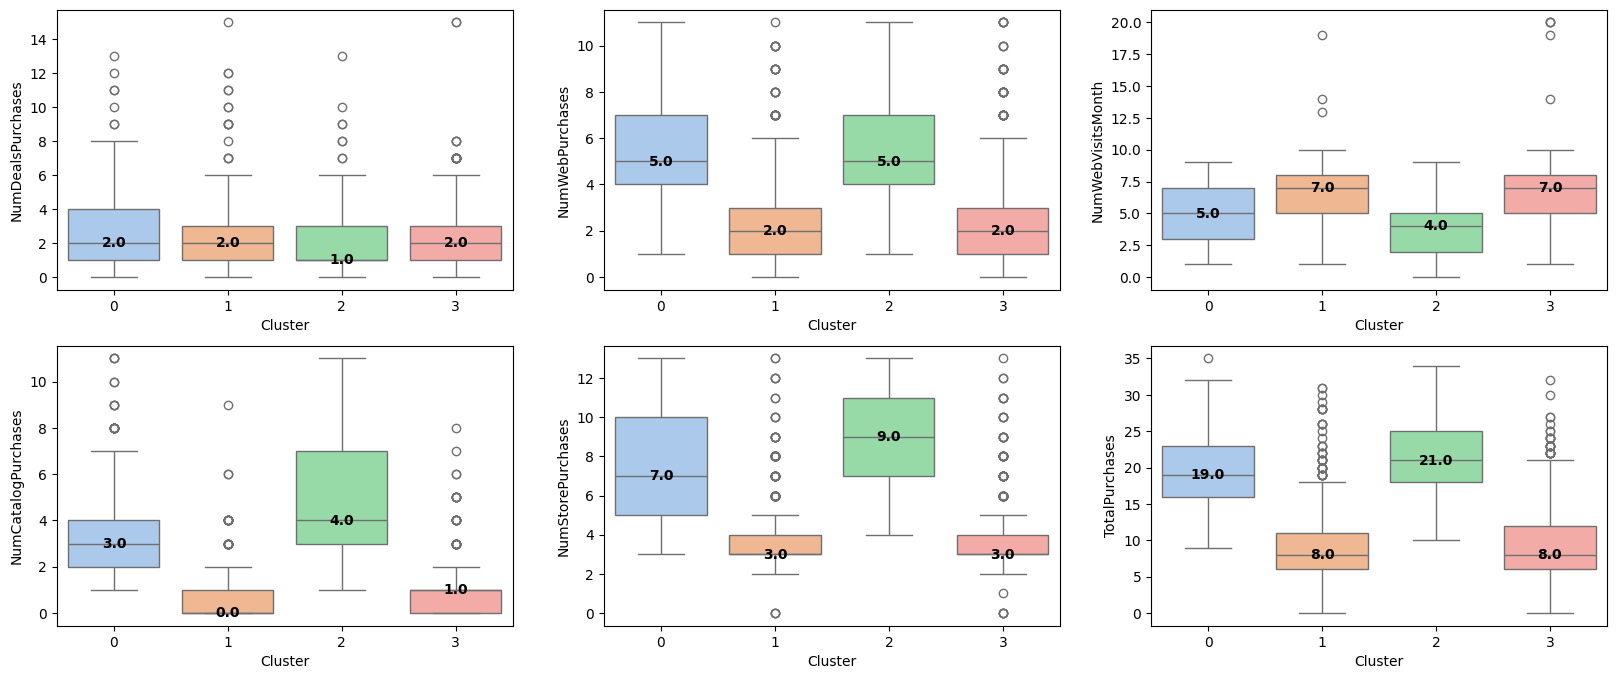

In [63]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)

sns.boxplot(x='Cluster', y='NumDealsPurchases', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,0]))
medians = df_clust_pca_kmeans.groupby('Cluster')['NumDealsPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='NumWebPurchases', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,1]))
medians = df_clust_pca_kmeans.groupby('Cluster')['NumWebPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='NumWebVisitsMonth', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,2]))
medians = df_clust_pca_kmeans.groupby('Cluster')['NumWebVisitsMonth'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='NumCatalogPurchases', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,0]))
medians = df_clust_pca_kmeans.groupby('Cluster')['NumCatalogPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='NumStorePurchases', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,1]))
medians = df_clust_pca_kmeans.groupby('Cluster')['NumStorePurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='TotalPurchases', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[1,2]))
medians = df_clust_pca_kmeans.groupby('Cluster')['TotalPurchases'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')


> Recency | Age | ChildrenAtHome
---


*   The most recent cluster are 1 and 2. The less frequent is 3, with a median of Recency of 75 days.





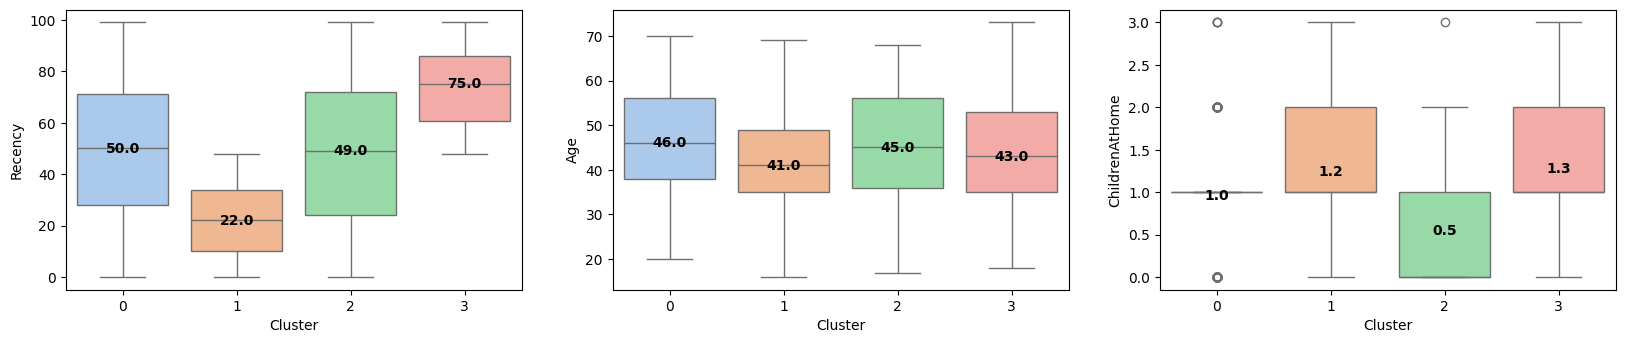

In [90]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(2,3)
sns.boxplot(x='Cluster', y='Recency', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,0]))
medians = df_clust_pca_kmeans.groupby('Cluster')['Recency'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='Age', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,1]))
medians = df_clust_pca_kmeans.groupby('Cluster')['Age'].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

sns.boxplot(x='Cluster', y='ChildrenAtHome', data=df_clust_pca_kmeans, palette="pastel", hue='Cluster', legend=False, ax=fig.add_subplot(gs[0,2]))
medians = df_clust_pca_kmeans.groupby('Cluster')['ChildrenAtHome'].mean()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.1f}', ha='center', va='center', color='black', fontsize=10, weight='bold')

> Response
---

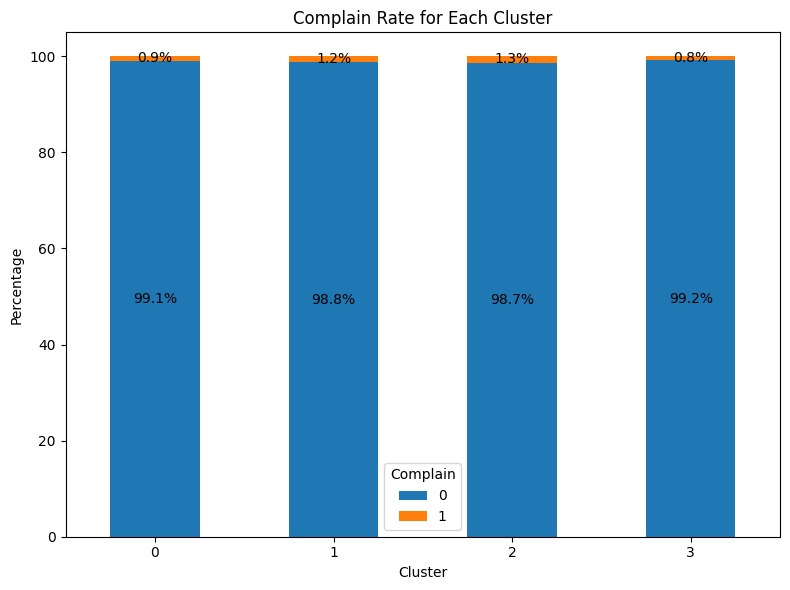

In [65]:
# Calculate the Complain rate for each cluster
Complain_rate = df_clust_pca_kmeans.groupby('Cluster')['Complain'].value_counts(normalize=True).unstack() * 100

# Plot the stacked bar chart
ax = Complain_rate.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Complain Rate for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Add percentage labels on top of each bar section
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.legend(title='Complain')
plt.tight_layout()
plt.show()

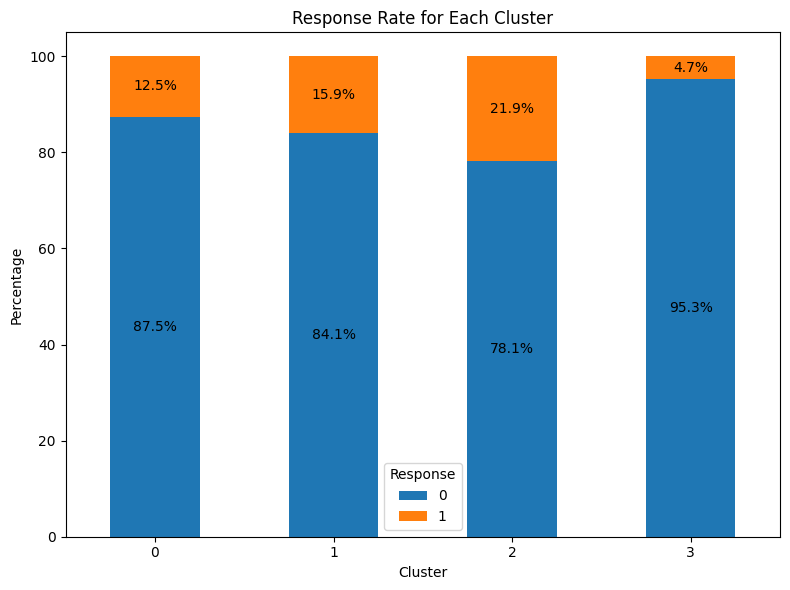

In [66]:
import matplotlib.pyplot as plt

# Assuming df_clust_pca_kmeans is your DataFrame and 'Cluster' contains cluster labels

# Calculate the response rate for each cluster
response_rate = df_clust_pca_kmeans.groupby('Cluster')['Response'].value_counts(normalize=True).unstack() * 100

# Plot the stacked bar chart
ax = response_rate.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Response Rate for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Add percentage labels on top of each bar section
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.legend(title='Response')
plt.tight_layout()
plt.show()

> ChildreAtHome by Cluster

In [67]:
# Calculate the average of 'ChildrenAtHome' by 'Cluster'
average_children_by_cluster = df_clust_pca_kmeans.groupby('Cluster')['ChildrenAtHome'].mean().round(1).reset_index()
average_children_by_cluster.columns = ['Cluster', 'AverageChildrenAtHome']

average_children_by_cluster

,Cluster,AverageChildrenAtHome
0,0,1.0
1,1,1.2
2,2,0.5
3,3,1.3


# 4. Predictive Model

> We'll try a RandomForest model, and then follow to Logit Model, since it is more appropriated to predict probabilities for Response.

> Droppping categorical variables and the ones which are tranformations of others

In [68]:
df_r_forest = df_clust_pca_kmeans.drop(columns = ['ID', 'Dt_Customer', 'Year_Customer', 'TotalCampaignsAccepted', 'Spent', 'TotalPurchases', 'AverageSpend', 'HasChildren', 'ChildrenAtHome', 'EducationLevel', 'InHouse'])

> Encoding Education and Marital_Status as it seem to be relevant demographical variables to explain behavior

In [69]:
# Use one-hot encoding for categorical columns
df_r_forest_encoded = pd.get_dummies(df_r_forest, columns=['Education', 'Marital_Status'], drop_first=True)

> Set train and test partitions of dataframe and performing model fitting

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define your feature set (X) and target (y)
X = df_r_forest_encoded.drop(columns = ['Response'])

y = df_r_forest_encoded['Response']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.896551724137931
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       457
           1       0.76      0.25      0.37        65

    accuracy                           0.90       522
   macro avg       0.83      0.62      0.66       522
weighted avg       0.88      0.90      0.87       522



> Confusion Matrix
---

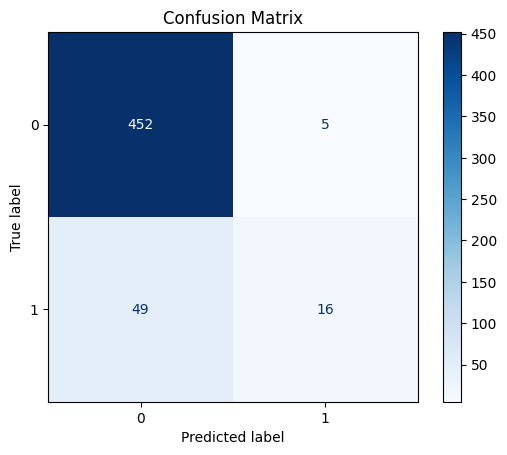

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

> From the matrix above, we can see that our model struggles with Label 1, as it generates a high number of false positives. This issue arises from the representativeness of this label in our dataset, which accounts for only 12.2% of the sample. In contrast, the model performs significantly better with Label 0.

> Label Proportion for Response
----

In [72]:
# Assuming df_clust_pca_kmeans is your DataFrame
response_counts = df_clust_pca_kmeans['Response'].value_counts(normalize=True).reset_index()
response_counts['proportion'] = round(response_counts['proportion'] * 100, 1)
response_counts.columns = ['Response', 'Proportion']
response_counts

,Response,Proportion
0,0,87.8
1,1,12.2


**Since we have an unbalanced distribution between labels of response, it is more appropriated to use a Logit Regression**
---

> Logistic Regression
---

In [73]:
df_log_reg = df_r_forest_encoded

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_log_reg.drop('Response', axis=1)
y = df_log_reg['Response']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
logreg_model.fit(X_train, y_train)

# Predict probabilities on the entire dataset to get probability of response for each row
df_log_reg['Probability_Response'] = logreg_model.predict_proba(X)[:, 1]

# Evaluate the model on the test set (AUC score)
y_pred_prob = logreg_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score on Test Set: {auc_score}")

# Display the first 5 rows with the new Probability_Response column
print(df_log_reg[['Probability_Response']].head())

# Further evaluation metrics
y_pred = logreg_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


AUC Score on Test Set: 0.757835381248948
   Probability_Response
0              0.067154
1              0.028469
2              0.053347
3              0.011764
4              0.126510
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       457
           1       0.45      0.15      0.23        65

    accuracy                           0.87       522
   macro avg       0.67      0.56      0.58       522
weighted avg       0.84      0.87      0.84       522

[[445  12]
 [ 55  10]]


In [75]:
# Filter the DataFrame where Probability_Response is upper than 0.5
filtered_df = df_log_reg[(df_log_reg['Probability_Response'] > 0.5)]

# Group by 'Response' and count
response_counts = filtered_df.groupby('Response').size().reset_index(name='Count')

response_counts

,Response,Count
0,0,36
1,1,36


In [76]:
35/69

0.5072463768115942

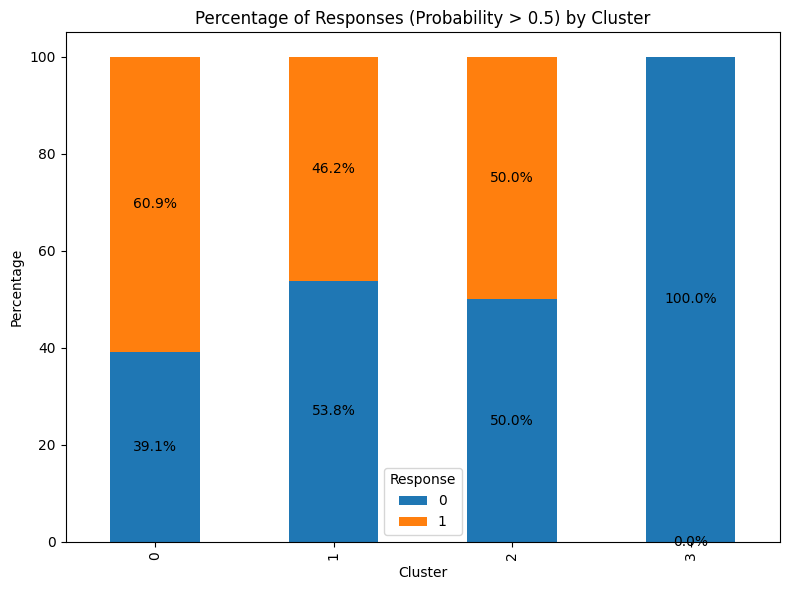

In [77]:
# Calculate the percentage of responses with Probability_Response > 0.5 for each cluster
cluster_percentages = df_log_reg[(df_log_reg['Probability_Response'] > 0.5)] \
    .groupby('Cluster')['Response'] \
    .value_counts(normalize=True) \
    .unstack() * 100

# Plot the results
cluster_percentages.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Percentage of Responses (Probability > 0.5) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')

# Add percentage labels on top of each bar section
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.legend(title='Response')
plt.tight_layout()
plt.show()

Is very difficult predict the behavior of cluster 3. They are the less Recent (75 days since last purchase)